In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lime.lime_tabular
import warnings
from sklearn.exceptions import ConvergenceWarning

In [99]:
# Suppress the ConvergenceWarning and FutureWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
# Set the random state value
rs = 734

In [5]:
# Downloading data
path = kagglehub.dataset_download("shantanugarg274/heart-prediction-dataset-quantum")

data = pd.read_csv(path + "\\Heart Prediction Quantum Dataset.csv")
data.head()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    500 non-null    int64  
 1   Gender                 500 non-null    int64  
 2   BloodPressure          500 non-null    int64  
 3   Cholesterol            500 non-null    int64  
 4   HeartRate              500 non-null    int64  
 5   QuantumPatternFeature  500 non-null    float64
 6   HeartDisease           500 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 27.5 KB


In [7]:
data.describe()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,54.864000,0.468000,132.874000,221.50000,88.766000,8.317407,0.600000
std,14.315004,0.499475,26.418516,43.86363,17.417289,0.919629,0.490389
min,30.000000,0.000000,90.000000,150.00000,60.000000,6.164692,0.000000
25%,43.000000,0.000000,111.000000,183.75000,73.000000,7.675779,0.000000
50%,55.000000,0.000000,132.000000,221.00000,89.000000,8.323064,1.000000
75%,66.250000,1.000000,155.000000,258.00000,104.000000,8.935999,1.000000
max,79.000000,1.000000,179.000000,299.00000,119.000000,10.784886,1.000000


Gender                   0.128649
Cholesterol              0.096326
QuantumPatternFeature    0.075851
BloodPressure            0.075715
HeartRate               -0.003976
Age                     -0.105914
HeartDisease            -0.409478
dtype: float64


<Axes: xlabel='HeartDisease'>

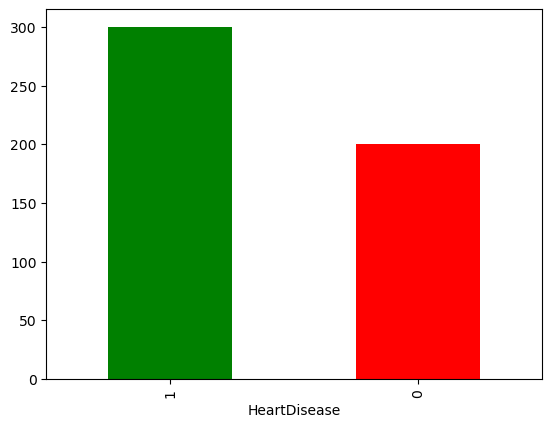

In [8]:
# Calculate skewness for numeric columns
skewness = data.skew()

# Display skewness values
print(skewness.sort_values(ascending=False))

# Visualize the count for each class
data['HeartDisease'].value_counts().plot.bar(color=['green', 'red'])

Skewness between 0.5 and -0.5 for all values suggesting no action required. HeartDisease has a minor class imbalance and could potentially benefit from overfitting, underfitting, or weighting but should work well as it is.

In [9]:
# Scoring
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score, zero_division=0),  # handle ill-defined precision
    'f1': make_scorer(f1_score)
}

# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga'],
    'C': [1, 0.5, 0.1, 0.01],
    'class_weight': [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]
    }
    # Create the logustic regression model
    lr_model = LogisticRegression(random_state=rs, max_iter=10000)
    # Set up the GridSearchCV
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring=scorers,
                           refit='f1',  # Fitting the best based on F1 score
                           cv = 5,
                           verbose = 1)
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    return grid_search

# Grid search hyperparameters for a decision tree model
def grid_search_dt(X_train, y_train):
    # Define the parameter grid for the Decision Tree
    params_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2'],
        'class_weight': [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]
    }
    # Create the decision tree model
    dt_model = DecisionTreeClassifier(random_state=rs)
    # Set up the GridSearchCV
    grid_search = GridSearchCV(estimator = dt_model, 
                               param_grid = params_grid, 
                               scoring=scorers,
                               refit='f1', 
                               cv=5, 
                               verbose=1)    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    return grid_search

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]
    }
    # Create the random forest model
    rf_model = RandomForestClassifier(random_state=rs)
    # Set up the GridSearchCV
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring=scorers,
                           refit='f1',
                           cv = 5,
                           verbose = 1)
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    return grid_search

In [10]:
X = data.drop('HeartDisease', axis=1)  # Features
y = data['HeartDisease']  # Target variable

# Scale for benefit of Logistic Regression
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Get the optimal parameters for Logistic Regression
lr_grid_search = grid_search_lr(X_scaled, y)
lr_results = pd.DataFrame(lr_grid_search.cv_results_)

# Get the optimal parameters for Decision Tree
dt_grid_search = grid_search_dt(X, y)
dt_results = pd.DataFrame(dt_grid_search.cv_results_)

# Get the optimal parameters for Random Forest
rf_grid_search = grid_search_rf(X, y)
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [11]:
filtered_lr_results = lr_results.filter(like='param_').join(lr_results.filter(like='mean_'))
filtered_lr_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
23,0.5,"{0: 0.5, 1: 0.5}",l1,saga,0.013450,0.024561,0.924,0.940000,0.920000,0.933904,0.936643
11,1.0,"{0: 0.5, 1: 0.5}",l1,saga,0.021639,0.024541,0.924,0.933333,0.921667,0.939934,0.936152
10,1.0,"{0: 0.5, 1: 0.5}",l1,liblinear,0.007666,0.023363,0.924,0.930000,0.922500,0.943050,0.936137
22,0.5,"{0: 0.5, 1: 0.5}",l1,liblinear,0.005718,0.022094,0.920,0.930000,0.917500,0.936444,0.932979
7,1.0,"{0: 0.4, 1: 0.6}",l1,saga,0.022720,0.025098,0.910,0.953333,0.899167,0.902812,0.927001


In [12]:
filtered_dt_results = dt_results.filter(like='param_').join(dt_results.filter(like='mean_'))
filtered_dt_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
364,"{0: 0.5, 1: 0.5}",entropy,5,None,4,2,0.008750,0.025731,0.920,0.926667,0.918333,0.940684,0.932628
365,"{0: 0.5, 1: 0.5}",entropy,5,None,4,5,0.008747,0.026925,0.920,0.926667,0.918333,0.940684,0.932628
400,"{0: 0.5, 1: 0.5}",entropy,15,None,4,2,0.008680,0.025701,0.908,0.926667,0.903333,0.920736,0.923334
401,"{0: 0.5, 1: 0.5}",entropy,15,None,4,5,0.007584,0.026775,0.908,0.926667,0.903333,0.920736,0.923334
382,"{0: 0.5, 1: 0.5}",entropy,10,None,4,2,0.008272,0.030721,0.908,0.926667,0.903333,0.920736,0.923334


In [13]:
filtered_rf_results = rf_results.filter(like='param_').join(rf_results.filter(like='mean_'))
filtered_rf_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
676,"{0: 0.4, 1: 0.6}",entropy,5,sqrt,2,5,50,0.139293,0.025138,0.924,0.933333,0.921667,0.939435,0.935985
694,"{0: 0.4, 1: 0.6}",entropy,5,log2,2,5,50,0.143351,0.025176,0.924,0.933333,0.921667,0.939435,0.935985
256,"{0: 0.3, 1: 0.7}",entropy,5,log2,1,5,50,0.144351,0.024901,0.922,0.950000,0.915000,0.922646,0.935839
238,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,1,5,50,0.147055,0.026271,0.922,0.950000,0.915000,0.922646,0.935839
239,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,1,5,100,0.279500,0.031195,0.922,0.950000,0.915000,0.922658,0.935718


In [14]:
def resample(X, y):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 734)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=734)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X, y)
    X_under, y_under = under_sampler.fit_resample(X, y)
    return X_smo, y_smo, X_under, y_under

In [15]:
X_smo, y_smo, X_under, y_under = resample(X, y)

# Scale for benefit of Logistic Regression
scaler = MinMaxScaler()
X_smo_scaled = scaler.fit_transform(X_smo)
X_under_scaled = scaler.transform(X_under)

In [16]:
# Get the optimal parameters for Logistic Regression
lr_grid_search = grid_search_lr(X_smo_scaled, y_smo)
lr_smo_results = pd.DataFrame(lr_grid_search.cv_results_)

# Get the optimal parameters for Decision Tree
dt_grid_search = grid_search_dt(X_smo, y_smo)
dt_smo_results = pd.DataFrame(dt_grid_search.cv_results_)

# Get the optimal parameters for Random Forest
rf_grid_search = grid_search_rf(X_smo, y_smo)
rf_smo_results = pd.DataFrame(rf_grid_search.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [17]:
filtered_lr_smo_results = lr_smo_results.filter(like='param_').join(lr_smo_results.filter(like='mean_'))
filtered_lr_smo_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
10,1.0,"{0: 0.5, 1: 0.5}",l1,liblinear,0.007854,0.023091,0.941667,0.920000,0.941667,0.961609,0.940157
35,0.1,"{0: 0.5, 1: 0.5}",l1,saga,0.006226,0.019239,0.941667,0.910000,0.941667,0.971208,0.939481
22,0.5,"{0: 0.5, 1: 0.5}",l1,liblinear,0.006184,0.019798,0.940000,0.910000,0.940000,0.967929,0.937819
11,1.0,"{0: 0.5, 1: 0.5}",l1,saga,0.025294,0.023106,0.938333,0.926667,0.938333,0.949010,0.937580
23,0.5,"{0: 0.5, 1: 0.5}",l1,saga,0.013667,0.019433,0.938333,0.920000,0.938333,0.955024,0.937033


In [18]:
filtered_dt_smo_results = dt_smo_results.filter(like='param_').join(dt_smo_results.filter(like='mean_'))
filtered_dt_smo_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
365,"{0: 0.5, 1: 0.5}",entropy,5,None,4,5,0.008409,0.020849,0.928333,0.883333,0.928333,0.970842,0.925004
364,"{0: 0.5, 1: 0.5}",entropy,5,None,4,2,0.007871,0.020802,0.928333,0.883333,0.928333,0.970842,0.925004
108,"{0: 0.3, 1: 0.7}",entropy,15,None,1,2,0.007855,0.018540,0.921667,0.910000,0.921667,0.932468,0.921001
126,"{0: 0.3, 1: 0.7}",entropy,20,None,1,2,0.007274,0.018510,0.921667,0.910000,0.921667,0.932468,0.921001
328,"{0: 0.5, 1: 0.5}",gini,15,None,4,2,0.005636,0.017499,0.920000,0.910000,0.920000,0.930396,0.919311


In [19]:
filtered_rf_smo_results = rf_smo_results.filter(like='param_').join(rf_smo_results.filter(like='mean_'))
filtered_rf_smo_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
1044,"{0: 0.5, 1: 0.5}",gini,20,sqrt,1,2,25,0.083498,0.024464,0.943333,0.933333,0.943333,0.952524,0.942551
990,"{0: 0.5, 1: 0.5}",gini,15,sqrt,1,2,25,0.079932,0.027238,0.943333,0.933333,0.943333,0.952524,0.942551
1008,"{0: 0.5, 1: 0.5}",gini,15,log2,1,2,25,0.095468,0.026452,0.943333,0.933333,0.943333,0.952524,0.942551
1062,"{0: 0.5, 1: 0.5}",gini,20,log2,1,2,25,0.084441,0.023766,0.943333,0.933333,0.943333,0.952524,0.942551
954,"{0: 0.5, 1: 0.5}",gini,10,log2,1,2,25,0.082086,0.025025,0.941667,0.930000,0.941667,0.952524,0.940783


In [20]:
# Get the optimal parameters for Logistic Regression
lr_grid_search = grid_search_lr(X_under_scaled, y_under)
lr_under_results = pd.DataFrame(lr_grid_search.cv_results_)

# Get the optimal parameters for Decision Tree
dt_grid_search = grid_search_dt(X_under, y_under)
dt_under_results = pd.DataFrame(dt_grid_search.cv_results_)

# Get the optimal parameters for Random Forest
rf_grid_search = grid_search_rf(X_under, y_under)
rf_under_results = pd.DataFrame(rf_grid_search.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [21]:
filtered_lr_under_results = lr_under_results.filter(like='param_').join(lr_under_results.filter(like='mean_'))
filtered_lr_under_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
10,1.0,"{0: 0.5, 1: 0.5}",l1,liblinear,0.005016,0.019096,0.9325,0.910,0.9325,0.953121,0.930712
22,0.5,"{0: 0.5, 1: 0.5}",l1,liblinear,0.004045,0.018129,0.9325,0.900,0.9325,0.963405,0.930176
11,1.0,"{0: 0.5, 1: 0.5}",l1,saga,0.014556,0.016912,0.9300,0.920,0.9300,0.939632,0.929070
35,0.1,"{0: 0.5, 1: 0.5}",l1,saga,0.005855,0.017859,0.9300,0.905,0.9300,0.952851,0.927986
23,0.5,"{0: 0.5, 1: 0.5}",l1,saga,0.008298,0.016184,0.9275,0.915,0.9275,0.939348,0.926273


In [22]:
filtered_dt_under_results = dt_under_results.filter(like='param_').join(dt_under_results.filter(like='mean_'))
filtered_dt_under_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
362,"{0: 0.5, 1: 0.5}",entropy,5,None,2,2,0.006720,0.020922,0.9125,0.855,0.9125,0.966540,0.906684
363,"{0: 0.5, 1: 0.5}",entropy,5,None,2,5,0.006694,0.021473,0.9125,0.855,0.9125,0.966540,0.906684
364,"{0: 0.5, 1: 0.5}",entropy,5,None,4,2,0.006143,0.020278,0.9100,0.870,0.9100,0.946130,0.905741
365,"{0: 0.5, 1: 0.5}",entropy,5,None,4,5,0.006215,0.020580,0.9100,0.870,0.9100,0.946130,0.905741
221,"{0: 0.4, 1: 0.6}",entropy,5,None,4,5,0.006646,0.020845,0.9075,0.880,0.9075,0.931393,0.904817


In [23]:
filtered_rf_under_results = rf_under_results.filter(like='param_').join(rf_under_results.filter(like='mean_'))
filtered_rf_under_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
1002,"{0: 0.5, 1: 0.5}",gini,15,sqrt,4,2,25,0.075232,0.024666,0.9275,0.895,0.9275,0.958077,0.924973
951,"{0: 0.5, 1: 0.5}",gini,10,sqrt,4,5,25,0.075937,0.023810,0.9275,0.895,0.9275,0.958077,0.924973
1077,"{0: 0.5, 1: 0.5}",gini,20,log2,4,5,25,0.074979,0.024226,0.9275,0.895,0.9275,0.958077,0.924973
1074,"{0: 0.5, 1: 0.5}",gini,20,log2,4,2,25,0.075285,0.022564,0.9275,0.895,0.9275,0.958077,0.924973
1059,"{0: 0.5, 1: 0.5}",gini,20,sqrt,4,5,25,0.076362,0.025232,0.9275,0.895,0.9275,0.958077,0.924973


In [24]:
print(f"{filtered_lr_results['mean_test_f1'].max()} , {filtered_lr_smo_results['mean_test_f1'].max()} , {filtered_lr_under_results['mean_test_f1'].max()}")
print(f"{filtered_dt_results['mean_test_f1'].max()} , {filtered_dt_smo_results['mean_test_f1'].max()} , {filtered_dt_under_results['mean_test_f1'].max()}")
print(f"{filtered_rf_results['mean_test_f1'].max()} , {filtered_rf_smo_results['mean_test_f1'].max()} , {filtered_rf_under_results['mean_test_f1'].max()}")

print(f"{filtered_lr_results['mean_test_recall'].max()} , {filtered_lr_smo_results['mean_test_recall'].max()} , {filtered_lr_under_results['mean_test_recall'].max()}")
print(f"{filtered_dt_results['mean_test_recall'].max()} , {filtered_dt_smo_results['mean_test_recall'].max()} , {filtered_dt_under_results['mean_test_recall'].max()}")
print(f"{filtered_rf_results['mean_test_recall'].max()} , {filtered_rf_smo_results['mean_test_recall'].max()} , {filtered_rf_under_results['mean_test_recall'].max()}")

0.9366434479854352 , 0.9401571938713736 , 0.9307122524377688
0.9326281485925703 , 0.9250038138825325 , 0.9066842379053235
0.9359845392301815 , 0.9425513511628208 , 0.9249733510992671
1.0 , 1.0 , 1.0
0.96 , 0.9466666666666667 , 0.9400000000000001
0.9533333333333334 , 0.95 , 0.9349999999999999


Undersampling worsened the f1 score and recall which are most important metrics for Heart Disease classification however oversampling sometimes performed better. As "perfect" recall could be achieved in Logistic Regression it could be considered the best model. The highest f1 score is still >0.86 which is still very high. The "perfect" recall might be as a result of a high number of positive Heart Disease predictions with very rare negative Heart Disease predictions. For Heart Disease classificatuon false positives are not as bad as false negatives this is because a false positive relates to wasted time and a false negative relates to death. There is another noteworthy Logistic Regression model with a recall of 0.99 and f1 score >0.9.

### Logistic Regression

In [25]:
filtered_lr_results[filtered_lr_results['mean_test_f1'] > 0.75].sort_values(by='mean_test_recall', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
35,0.1,"{0: 0.5, 1: 0.5}",l1,saga,0.006906,0.024164,0.812,1.000000,0.765000,0.761490,0.864578
31,0.1,"{0: 0.4, 1: 0.6}",l1,saga,0.006979,0.023375,0.656,1.000000,0.570000,0.635891,0.777339
29,0.1,"{0: 0.4, 1: 0.6}",l2,saga,0.006036,0.022743,0.630,1.000000,0.537500,0.618636,0.764369
13,0.5,"{0: 0.3, 1: 0.7}",l2,saga,0.005411,0.019236,0.722,1.000000,0.652500,0.683918,0.812137
28,0.1,"{0: 0.4, 1: 0.6}",l2,liblinear,0.003660,0.020694,0.632,0.996667,0.540833,0.620450,0.764753


In [26]:
filtered_lr_results[filtered_lr_results['mean_test_f1'] > 0.9].sort_values(by='mean_test_recall', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
15,0.5,"{0: 0.3, 1: 0.7}",l1,saga,0.011870,0.019750,0.870,0.990000,0.840000,0.827992,0.901434
2,1.0,"{0: 0.3, 1: 0.7}",l1,liblinear,0.007336,0.025009,0.886,0.980000,0.862500,0.853301,0.911570
3,1.0,"{0: 0.3, 1: 0.7}",l1,saga,0.021947,0.024827,0.882,0.963333,0.861667,0.858556,0.907223
18,0.5,"{0: 0.4, 1: 0.6}",l1,liblinear,0.005366,0.020308,0.892,0.963333,0.874167,0.871515,0.914408
6,1.0,"{0: 0.4, 1: 0.6}",l1,liblinear,0.005707,0.021097,0.906,0.960000,0.892500,0.891981,0.924348


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=rs)

# Define  logistic regression model
lr_recall_model = LogisticRegression(random_state=rs, penalty='l1', solver='saga', C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter = 10000)
lr_recall_model.fit(X_train, y_train)
lr_recall_preds = lr_recall_model.predict(X_test)
cf1 = confusion_matrix(y_test, lr_recall_preds)

# Define  logistic regression model
lr_f1_model = LogisticRegression(random_state=rs, penalty='l1', solver='saga', C=0.5, class_weight={0: 0.5, 1: 0.5}, max_iter = 10000)
lr_f1_model.fit(X_train, y_train)
lr_f1_preds = lr_f1_model.predict(X_test)
cf2 = confusion_matrix(y_test, lr_f1_preds)

# Define  logistic regression model
lr_rf1_model = LogisticRegression(random_state=rs, penalty='l1', solver='saga', C=0.5, class_weight={0: 0.3, 1: 0.7}, max_iter = 10000)
lr_rf1_model.fit(X_train, y_train)
lr_rf1_preds = lr_rf1_model.predict(X_test)
cf3 = confusion_matrix(y_test, lr_rf1_preds)

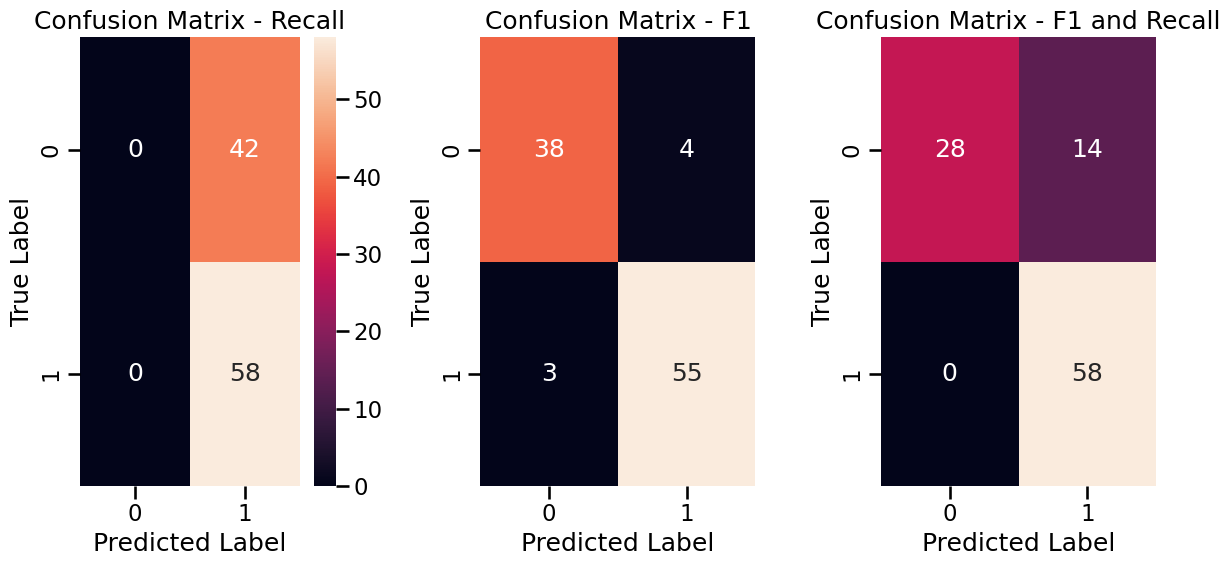

In [28]:
# Set the plot context for larger fonts and elements
sns.set_context('talk')

# Create the figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(cf1, annot=True, xticklabels=lr_recall_model.classes_, yticklabels=lr_recall_model.classes_, cbar=True)
plt.title("Confusion Matrix - Recall")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the second confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(cf2, annot=True, xticklabels=lr_recall_model.classes_, yticklabels=lr_recall_model.classes_, cbar=False)
plt.title("Confusion Matrix - F1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the third confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(cf3, annot=True, xticklabels=lr_recall_model.classes_, yticklabels=lr_recall_model.classes_, cbar=False)
plt.title("Confusion Matrix - F1 and Recall")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

For the training and test set it can be seen that the perdect recall model is very unlikely to predict Heart Disease as negative. The best F1 confusion matrix and the matrix with very high F1 and recall show different strengths with the best F1 matrix getting more precitions correct but the high F1 and recall matrix showing no false negatives.

In [29]:
# Extract and sort feature coefficients for binary classifiers
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        coef_dict[feat] = coef
    
    # Sort coefficients by their absolute value (to emphasize importance of features)
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}
    return coef_dict

# Generate bar colors based on whether the coefficient is positive or negative
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val < 0:
            color_vals.append('r')  # Red for negative coefficients (contributing to "No Heart Disease")
        else:
            color_vals.append('g')  # Green for positive coefficients (contributing to "Yes Heart Disease")
    return color_vals

# Visualize coefficients for binary classifiers
def visualize_coefs(coef_dict, title='Feature Coefficients for Binary Classifier'):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    
    # Get the colors based on the sign of the coefficient
    color_vals = get_bar_colors(values)
    
    # Plotting the horizontal bar chart
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust size for better readability
    ax.barh(y_pos, values, align='center', color=color_vals)  # Apply colors based on coefficient value
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    
    # Invert the y-axis to display the largest coefficient at the top
    ax.invert_yaxis()
    
    # Add labels and title
    ax.set_xlabel('Feature Coefficients')
    ax.set_title(title)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

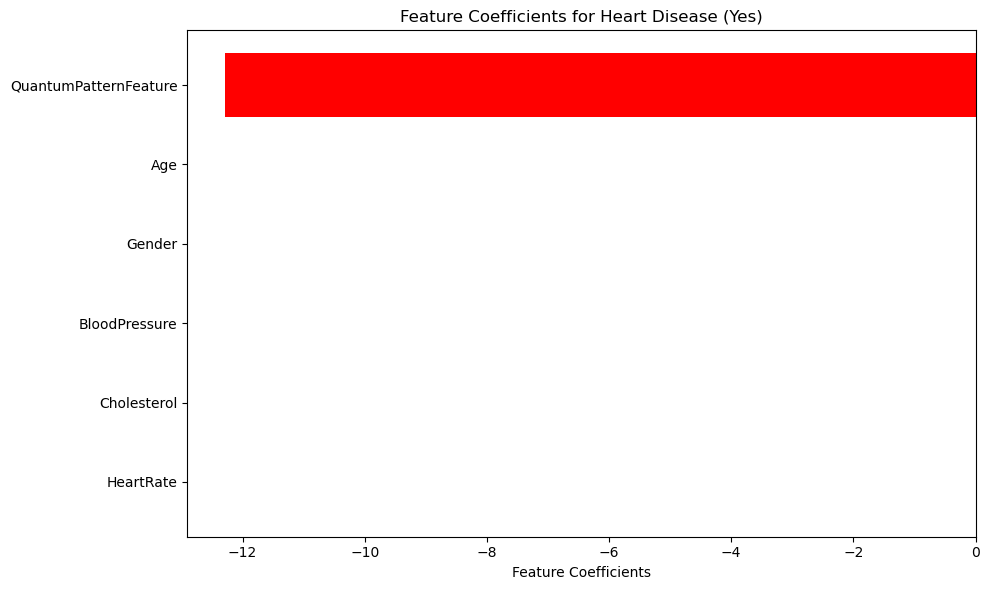

In [30]:
#Green is positive correlation with Heart Disease, red is negative correlation with Heart Disease
feature_columns = list(X.iloc[:, :].columns)
# Extract feature coefficients for class 1 (Heart Disease = Yes)
coef_dict_1 = get_feature_coefs(lr_rf1_model, label_index=0, columns=feature_columns)

# Visualize the coefficients for class 1 (Heart Disease = Yes)
visualize_coefs(coef_dict_1, title='Feature Coefficients for Heart Disease (Yes)')

Although, all three models produced a different matrix they all solely relied on the QuantumPatternFeature demonstrating that it can be a very good indicator for Heart Disease however, it also brings the question of how well could a model work if the feature is removed?

In [31]:
X_noQPF = data.drop(['HeartDisease','QuantumPatternFeature'], axis=1)  # Features
y = data['HeartDisease']  # Target variable

# Scale for benefit of Logistic Regression
scaler = MinMaxScaler()
X_noQPF_scaled = scaler.fit_transform(X_noQPF)

# Get the optimal parameters for Logistic Regression
lr_grid_search = grid_search_lr(X_noQPF_scaled, y)
lr_results = pd.DataFrame(lr_grid_search.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [32]:
filtered_lr_results = lr_results.filter(like='param_').join(lr_results.filter(like='mean_'))
filtered_lr_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
5,1.0,"{0: 0.4, 1: 0.6}",l2,saga,0.004945,0.017793,0.718,0.923333,0.666667,0.701713,0.797253
7,1.0,"{0: 0.4, 1: 0.6}",l1,saga,0.005103,0.018660,0.726,0.893333,0.684167,0.719202,0.796624
19,0.5,"{0: 0.4, 1: 0.6}",l1,saga,0.005080,0.018472,0.714,0.913333,0.664167,0.701620,0.793388
6,1.0,"{0: 0.4, 1: 0.6}",l1,liblinear,0.004528,0.018777,0.714,0.883333,0.671667,0.710528,0.787309
4,1.0,"{0: 0.4, 1: 0.6}",l2,liblinear,0.003040,0.017888,0.706,0.903333,0.656667,0.696804,0.786600


In [33]:
filtered_lr_results[filtered_lr_results['mean_test_f1'] > 0.75].sort_values(by='mean_test_recall', ascending=False).head(5)

,param_C,param_class_weight,param_penalty,param_solver,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
13,0.5,"{0: 0.3, 1: 0.7}",l2,saga,0.004636,0.016840,0.620,0.986667,0.528333,0.614289,0.756980
12,0.5,"{0: 0.3, 1: 0.7}",l2,liblinear,0.003454,0.018379,0.616,0.986667,0.523333,0.611738,0.755033
1,1.0,"{0: 0.3, 1: 0.7}",l2,saga,0.006199,0.018946,0.662,0.983333,0.581667,0.642869,0.777210
0,1.0,"{0: 0.3, 1: 0.7}",l2,liblinear,0.004169,0.018532,0.650,0.976667,0.568333,0.635855,0.770011
15,0.5,"{0: 0.3, 1: 0.7}",l1,saga,0.004353,0.016630,0.638,0.973333,0.554167,0.628220,0.763287


In [34]:
X_train_noQPF, X_test_noQPF, y_train, y_test = train_test_split(X_noQPF_scaled, y, test_size=0.2, random_state=rs)

# Define logistic regression model
lr_1_model_noQPF = LogisticRegression(random_state=rs, penalty='l2', solver='saga', C=1, class_weight={0: 0.4, 1: 0.6}, max_iter = 10000)
lr_1_model_noQPF.fit(X_train_noQPF, y_train)
lr_1_preds_noQPF = lr_1_model_noQPF.predict(X_test_noQPF)
cf1 = confusion_matrix(y_test, lr_1_preds_noQPF)

# Define logistic regression model
lr_2_model_noQPF = LogisticRegression(random_state=rs, penalty='l2', solver='saga', C=1, class_weight={0: 0.3, 1: 0.7}, max_iter = 10000)
lr_2_model_noQPF.fit(X_train_noQPF, y_train)
lr_2_preds_noQPF = lr_2_model_noQPF.predict(X_test_noQPF)
cf2 = confusion_matrix(y_test, lr_2_preds_noQPF)

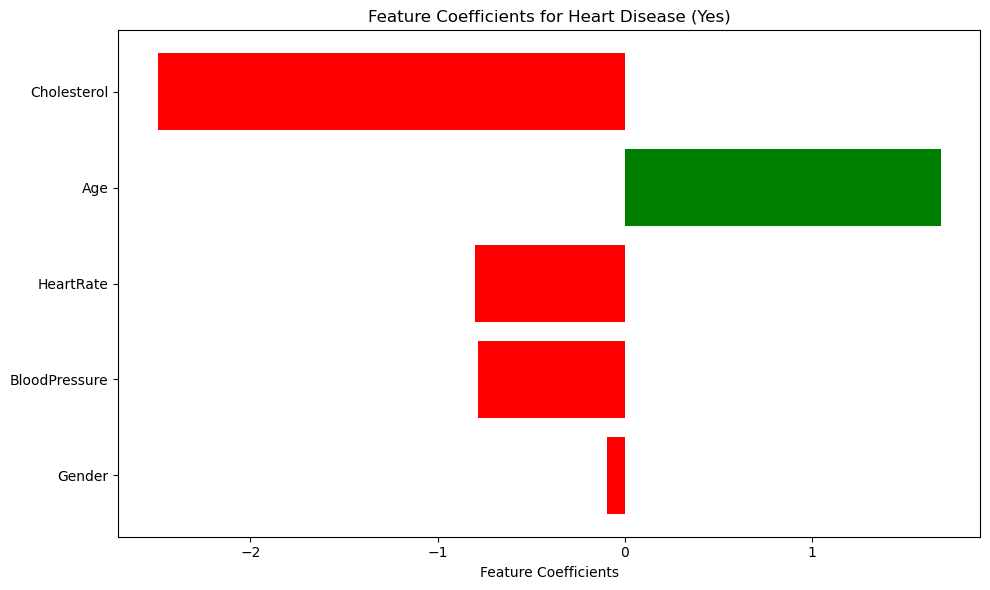

In [35]:
# Green is positive correlation with Heart Disease, red is negative correlation with Heart Disease
feature_columns = list(X_noQPF.iloc[:, :].columns)
# Extract feature coefficients for class 1 (Heart Disease = Yes)
coef_dict_1 = get_feature_coefs(lr_1_model_noQPF, label_index=0, columns=feature_columns)

# Visualize the coefficients for class 1 (Heart Disease = Yes)
visualize_coefs(coef_dict_1, title='Feature Coefficients for Heart Disease (Yes)')

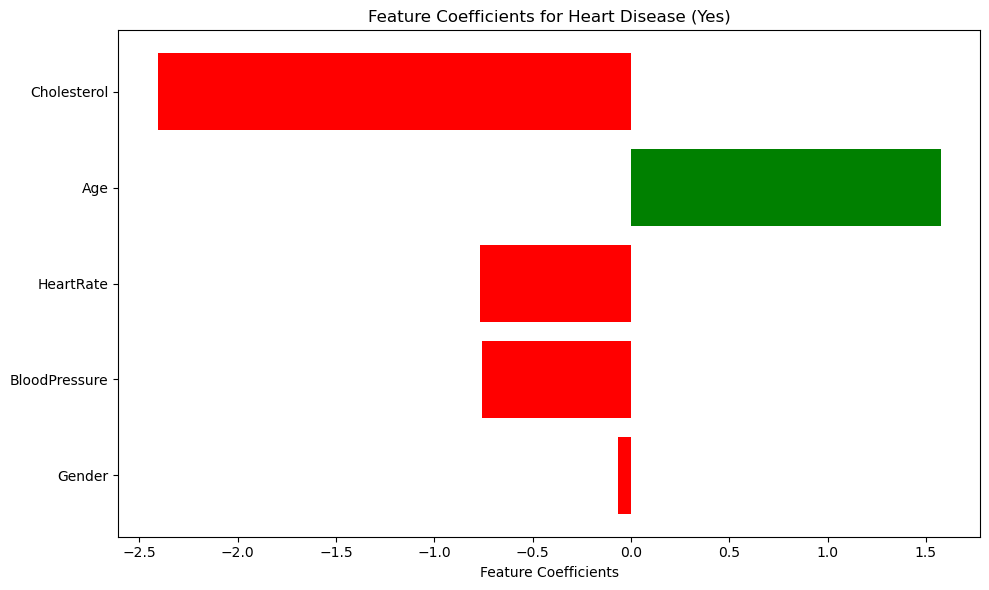

In [36]:
# Extract feature coefficients for class 1 (Heart Disease = Yes)
coef_dict_1 = get_feature_coefs(lr_2_model_noQPF, label_index=0, columns=feature_columns)

# Visualise the coefficients for class 1 (Heart Disease = Yes)
visualize_coefs(coef_dict_1, title='Feature Coefficients for Heart Disease (Yes)')

From these models we can see that cholesterol is the biggest indicator of heart disease but in this case it is low choleserol. Low heart rate and low blood pressure are also shown as indications of heart disease as well as high age. High age is to be expected as the body breaks down as it ages however, low cholesterol, heart rate and blood pressure could be an indication that simple positive or negative correlation might not be good for determining heart disease as both high and low instances of these features could indicate heart disease.

### Decision Tree

In [37]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.show()

In [38]:
feature_names = X.columns.values

In [39]:
filtered_dt_results[filtered_dt_results['mean_test_recall'] > 0.93].sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
149,"{0: 0.4, 1: 0.6}",gini,5,None,4,5,0.007844,0.026480,0.898,0.933333,0.889167,0.901546,0.916373
148,"{0: 0.4, 1: 0.6}",gini,5,None,4,2,0.008519,0.025905,0.898,0.933333,0.889167,0.901546,0.916373
95,"{0: 0.3, 1: 0.7}",entropy,10,None,4,5,0.008815,0.030020,0.894,0.940000,0.882500,0.890707,0.913886
130,"{0: 0.3, 1: 0.7}",entropy,20,None,4,2,0.007850,0.025226,0.894,0.940000,0.882500,0.890707,0.913886
94,"{0: 0.3, 1: 0.7}",entropy,10,None,4,2,0.008495,0.027418,0.894,0.940000,0.882500,0.890707,0.913886


In [40]:
# Define and train three models with high recall and f1 scores
dt_1_model = DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=rs)
dt_1_model.fit(X_train, y_train)

dt_2_model  = DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=rs)
dt_2_model.fit(X_train, y_train)

dt_3_model = DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=5, random_state=rs)
dt_3_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, max_depth=5,
                       min_samples_leaf=4, min_samples_split=5,
                       random_state=734)

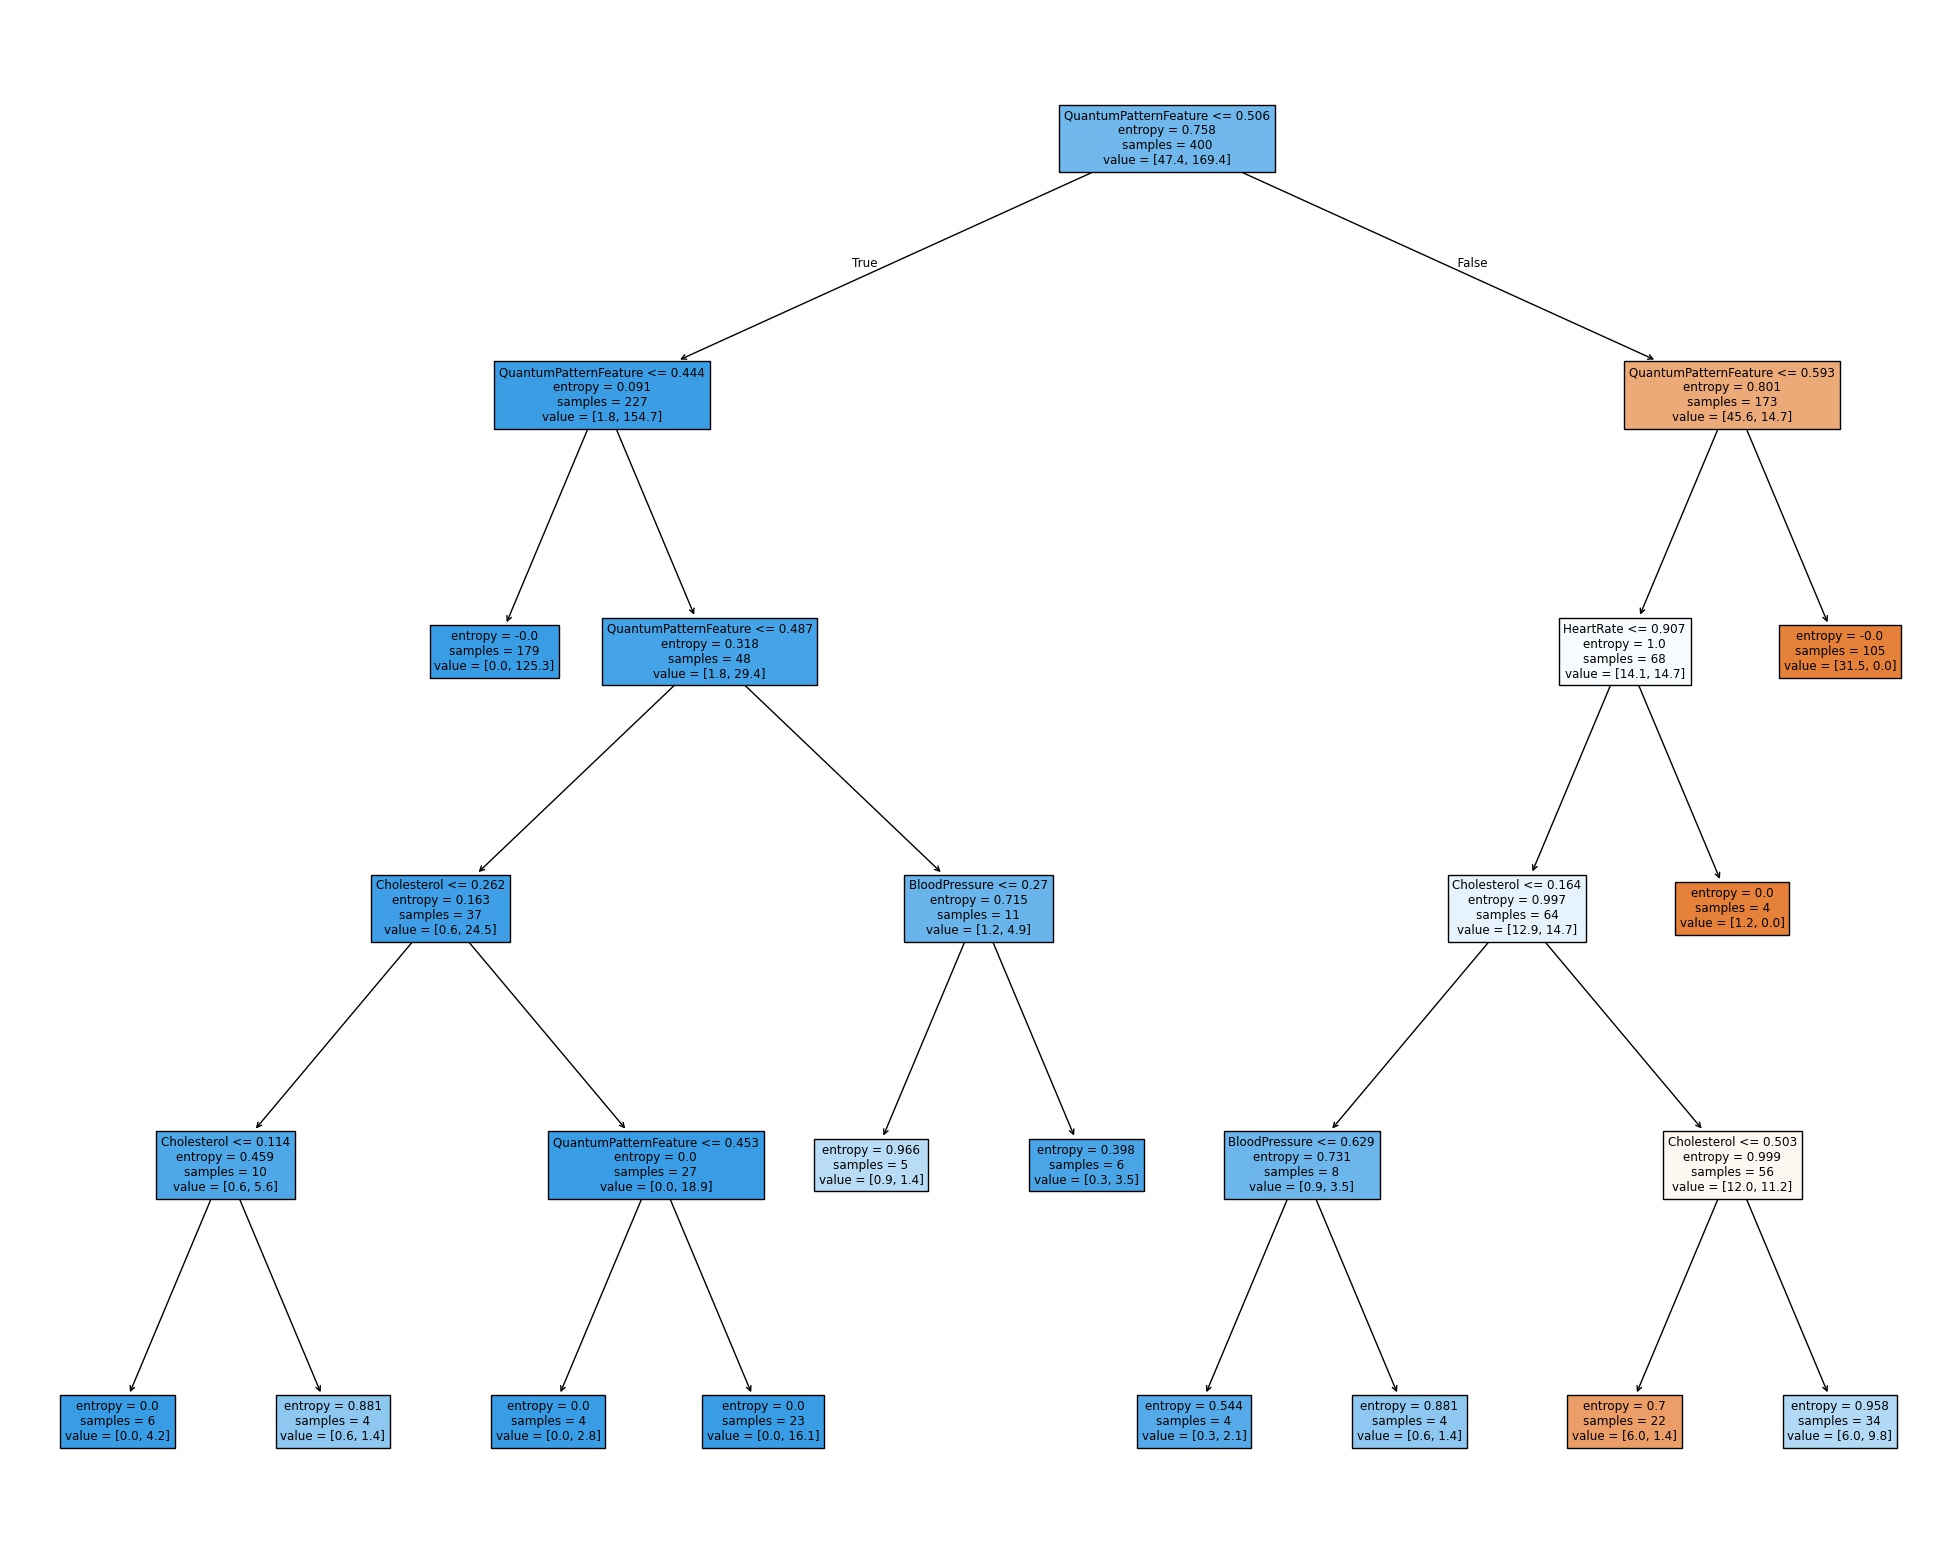

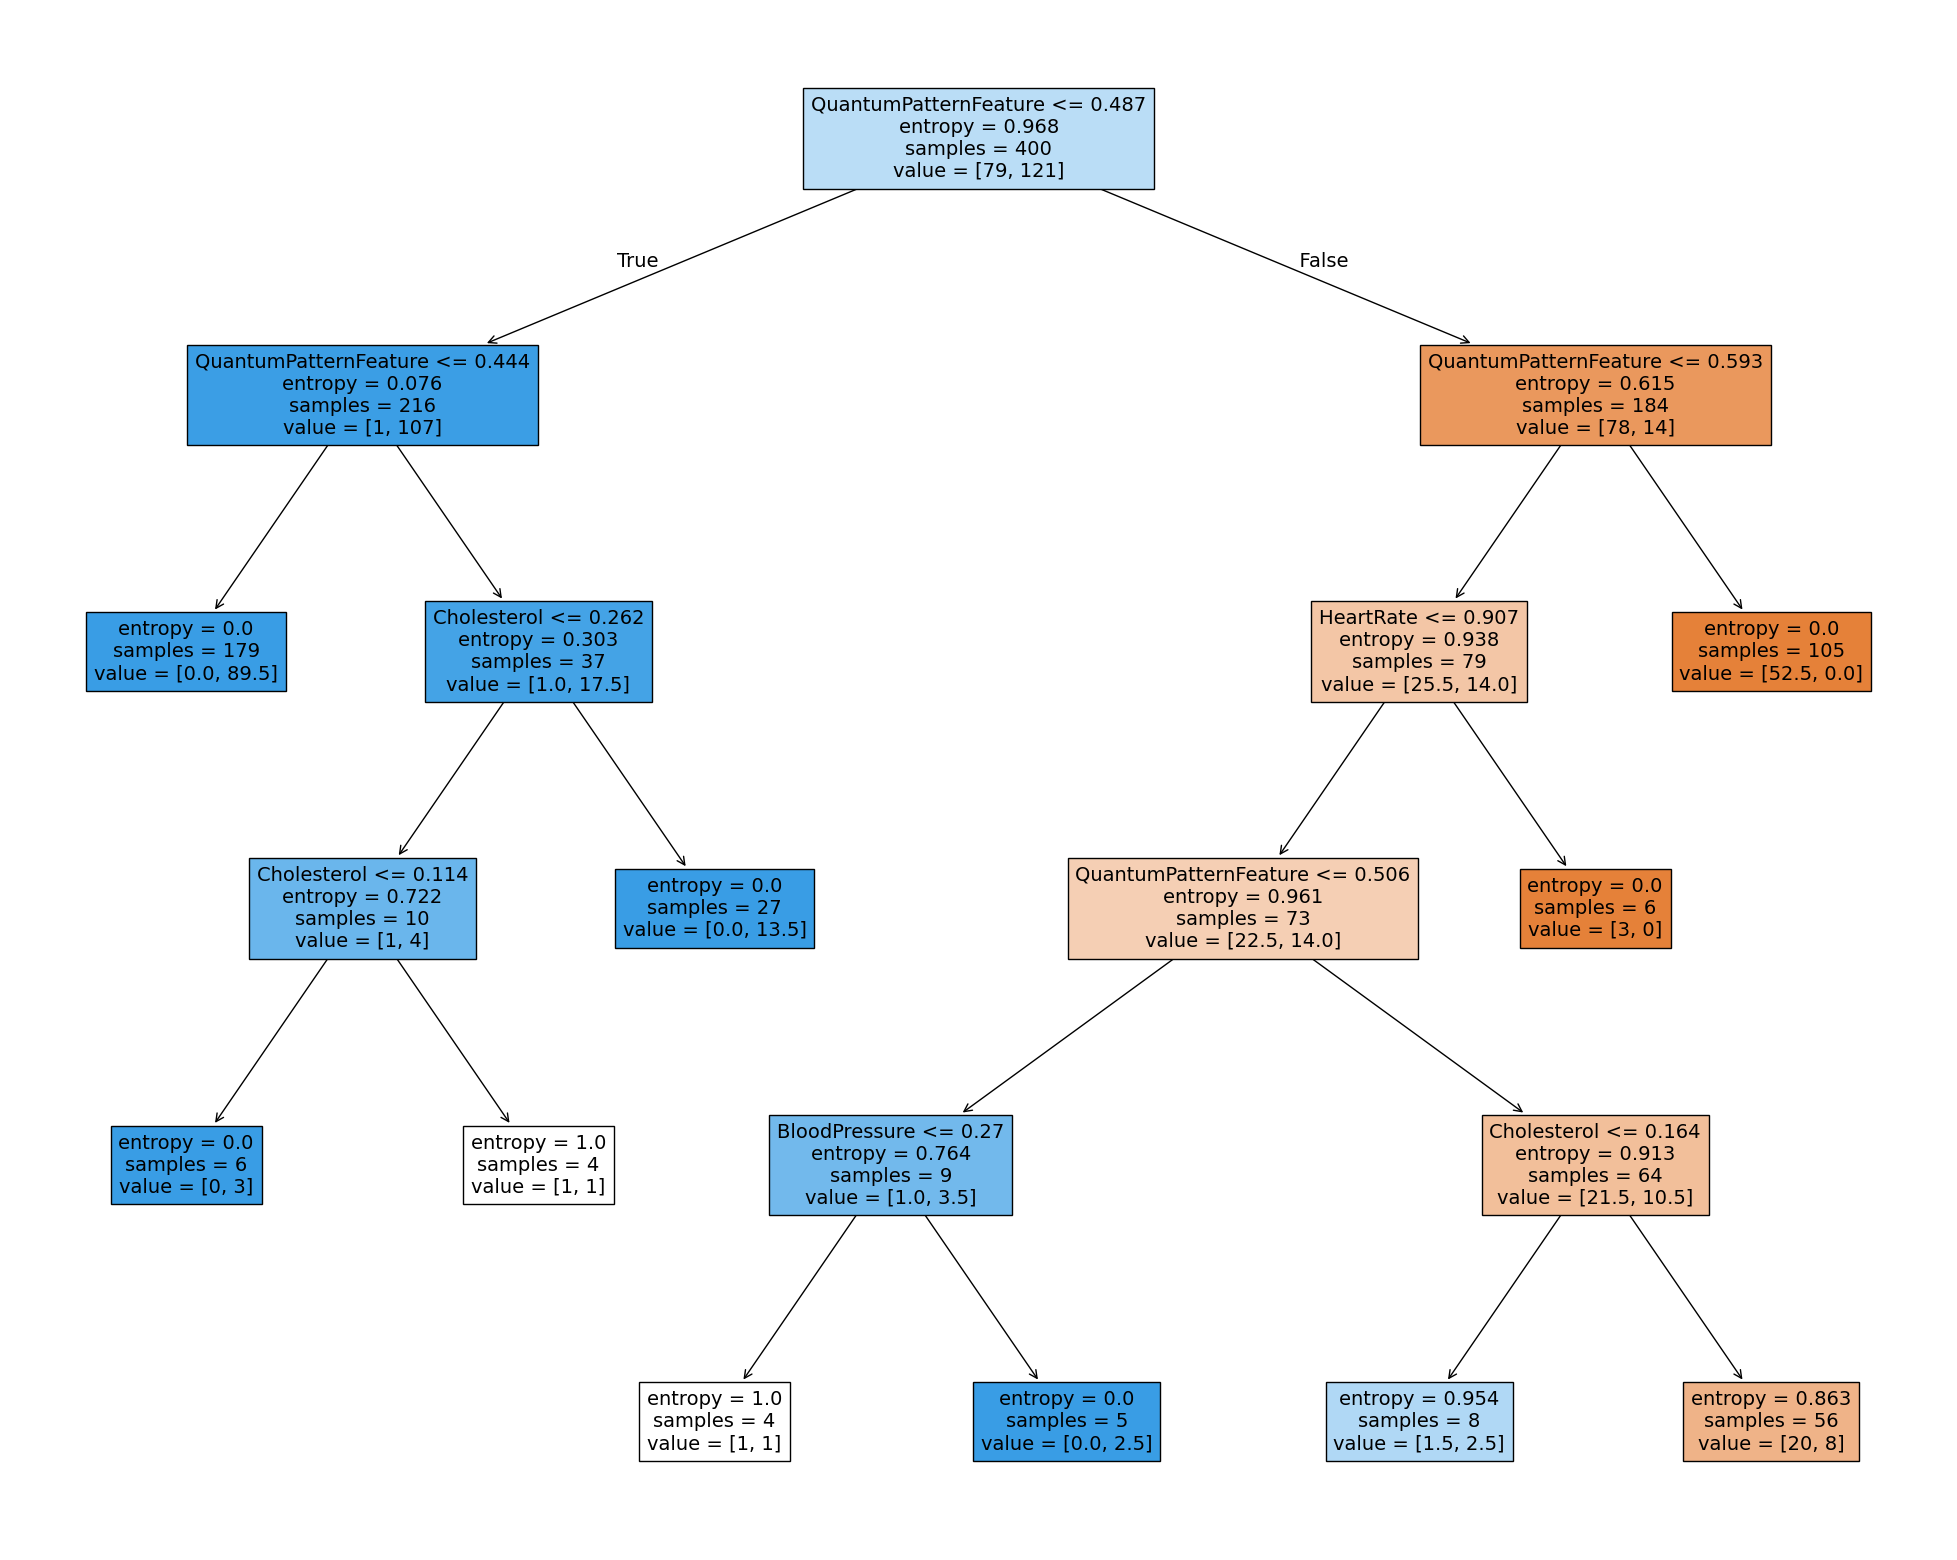

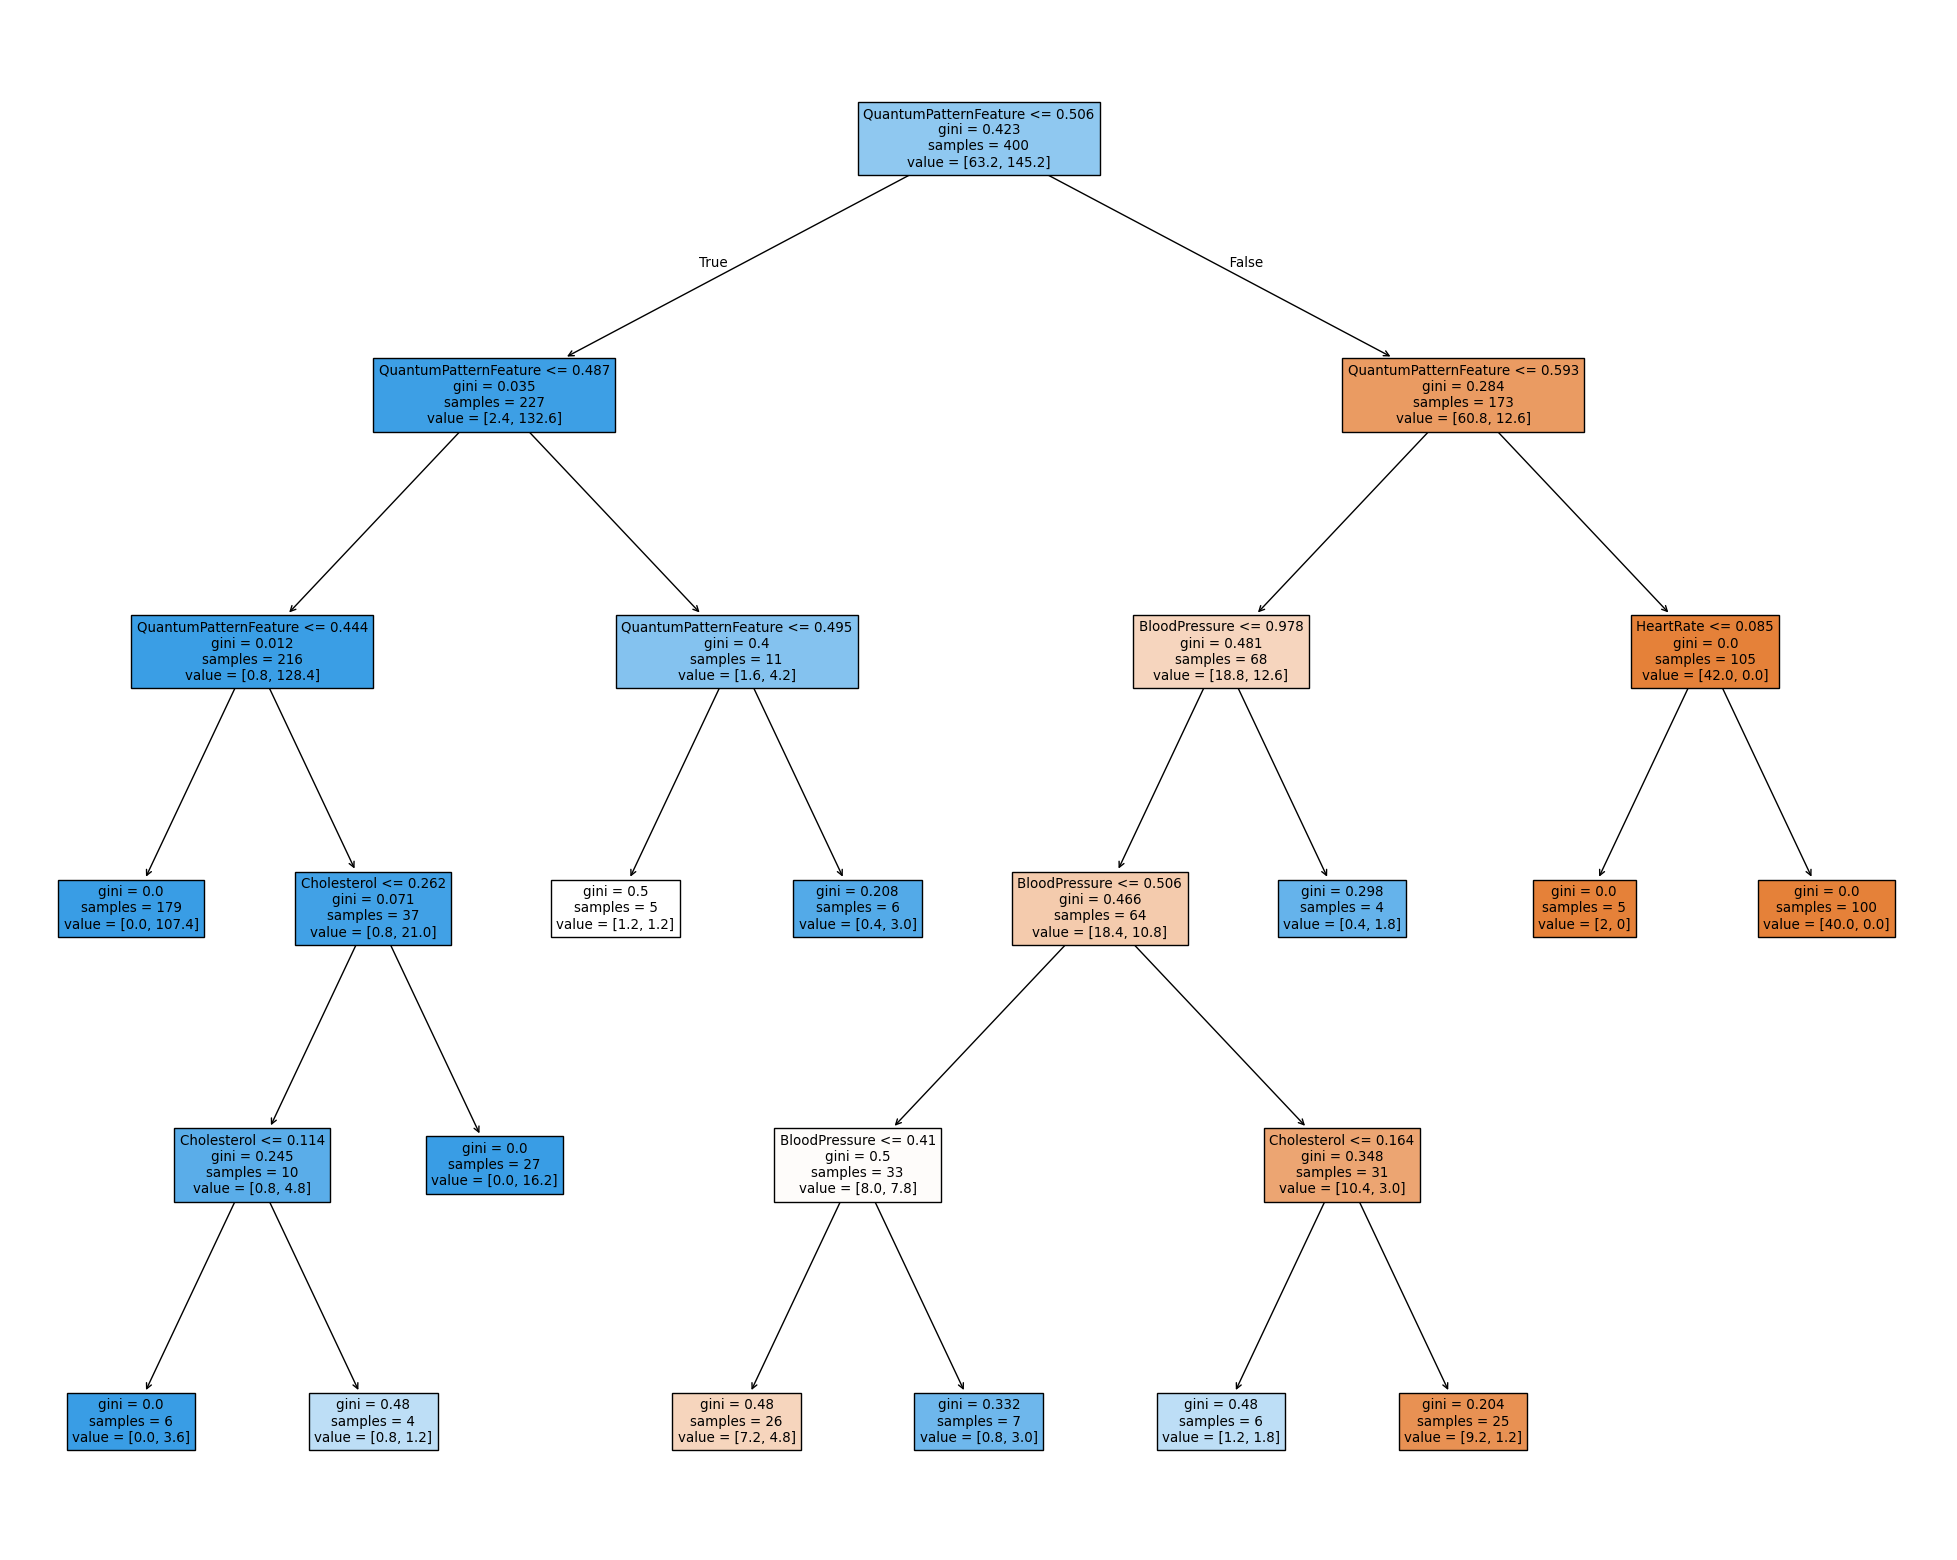

In [41]:
# Plot the decision trees
plot_decision_tree(dt_1_model, feature_names)
plot_decision_tree(dt_2_model, feature_names)
plot_decision_tree(dt_3_model, feature_names)

In each of the three high performing model QuantumPatternFeature is used to categorise a large proportion of people with heart disease. QuantumPatternFeature alone categorised 71% of people in the two entropy models while QuantumPatternFeature alone categorised 47.5% of people in the gini model. QuantumPatternFeature was used for the first two splits in all three models demonstrating that it is the most important and an effective feature for determining heart disease. Cholesterol appeared to be the main feature of choice to categorise low QuantumPatternFeature values where as HeartRate was the main feature of choice to categorise high QuantumPatternFeature values.

In [42]:
dt_1_preds = dt_1_model.predict(X_test)
dt_cf1 = confusion_matrix(y_test, dt_1_preds)
dt_2_preds = dt_2_model.predict(X_test)
dt_cf2 = confusion_matrix(y_test, dt_2_preds)
dt_3_preds = dt_3_model.predict(X_test)
dt_cf3 = confusion_matrix(y_test, dt_3_preds)

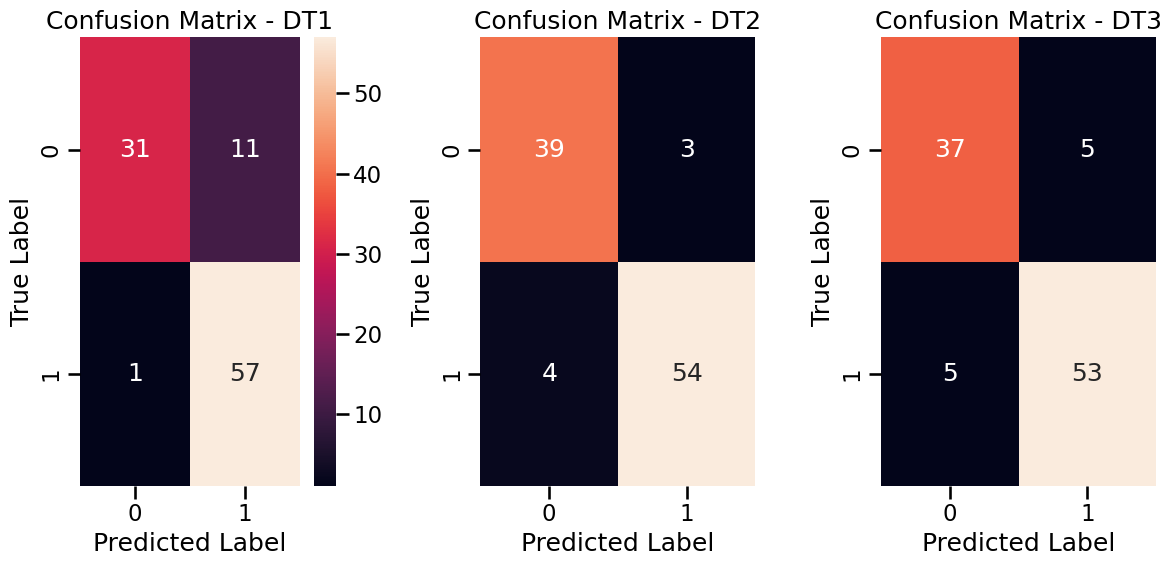

In [43]:
# Set the plot context for larger fonts and elements
sns.set_context('talk')

# Create the figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(dt_cf1, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=True)
plt.title("Confusion Matrix - DT1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the second confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(dt_cf2, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=False)
plt.title("Confusion Matrix - DT2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the third confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(dt_cf3, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=False)
plt.title("Confusion Matrix - DT3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

For the train test split, DT1 demonstrated the best ability to predict postive Heart Disease correctly. Although, DT2 and DT3 got more correct predictions, the consequence of not predicting Heart Disease when Heart Disease is present is much more severe.

In [44]:
# Get the optimal parameters for Decision Tree
dt_grid_search = grid_search_dt(X_noQPF, y)
dt_results = pd.DataFrame(dt_grid_search.cv_results_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [45]:
filtered_dt_results = dt_results.filter(like='param_').join(dt_results.filter(like='mean_'))
filtered_dt_results[filtered_dt_results['mean_test_recall'] > 0.85].sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
77,"{0: 0.3, 1: 0.7}",entropy,5,None,4,5,0.006065,0.020029,0.724,0.916667,0.675833,0.709901,0.799417
76,"{0: 0.3, 1: 0.7}",entropy,5,None,4,2,0.005484,0.017425,0.724,0.916667,0.675833,0.709901,0.799417
4,"{0: 0.3, 1: 0.7}",gini,5,None,4,2,0.005128,0.017581,0.734,0.866667,0.700833,0.741486,0.796725
5,"{0: 0.3, 1: 0.7}",gini,5,None,4,5,0.006025,0.018637,0.734,0.866667,0.700833,0.741486,0.796725
1,"{0: 0.3, 1: 0.7}",gini,5,None,1,5,0.005812,0.019137,0.732,0.860000,0.700000,0.739778,0.794022


It appears as though similar hyperparameters performed best even when QuantumPatternFeature was removed.

In [46]:
X_train_noQPF, X_test_noQPF, y_train, y_test = train_test_split(X_noQPF, y, test_size=0.2, random_state=rs)

In [47]:
# Define and train three models with high recall and f1 scores
dt_1_noQPF_model = DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=rs)
dt_1_noQPF_model.fit(X_train_noQPF, y_train)

dt_2_noQPF_model  = DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, criterion='entropy', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=rs)
dt_2_noQPF_model.fit(X_train_noQPF, y_train)

dt_3_noQPF_model = DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=5, random_state=rs)
dt_3_noQPF_model.fit(X_train_noQPF, y_train)

DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, max_depth=5,
                       min_samples_leaf=4, min_samples_split=5,
                       random_state=734)

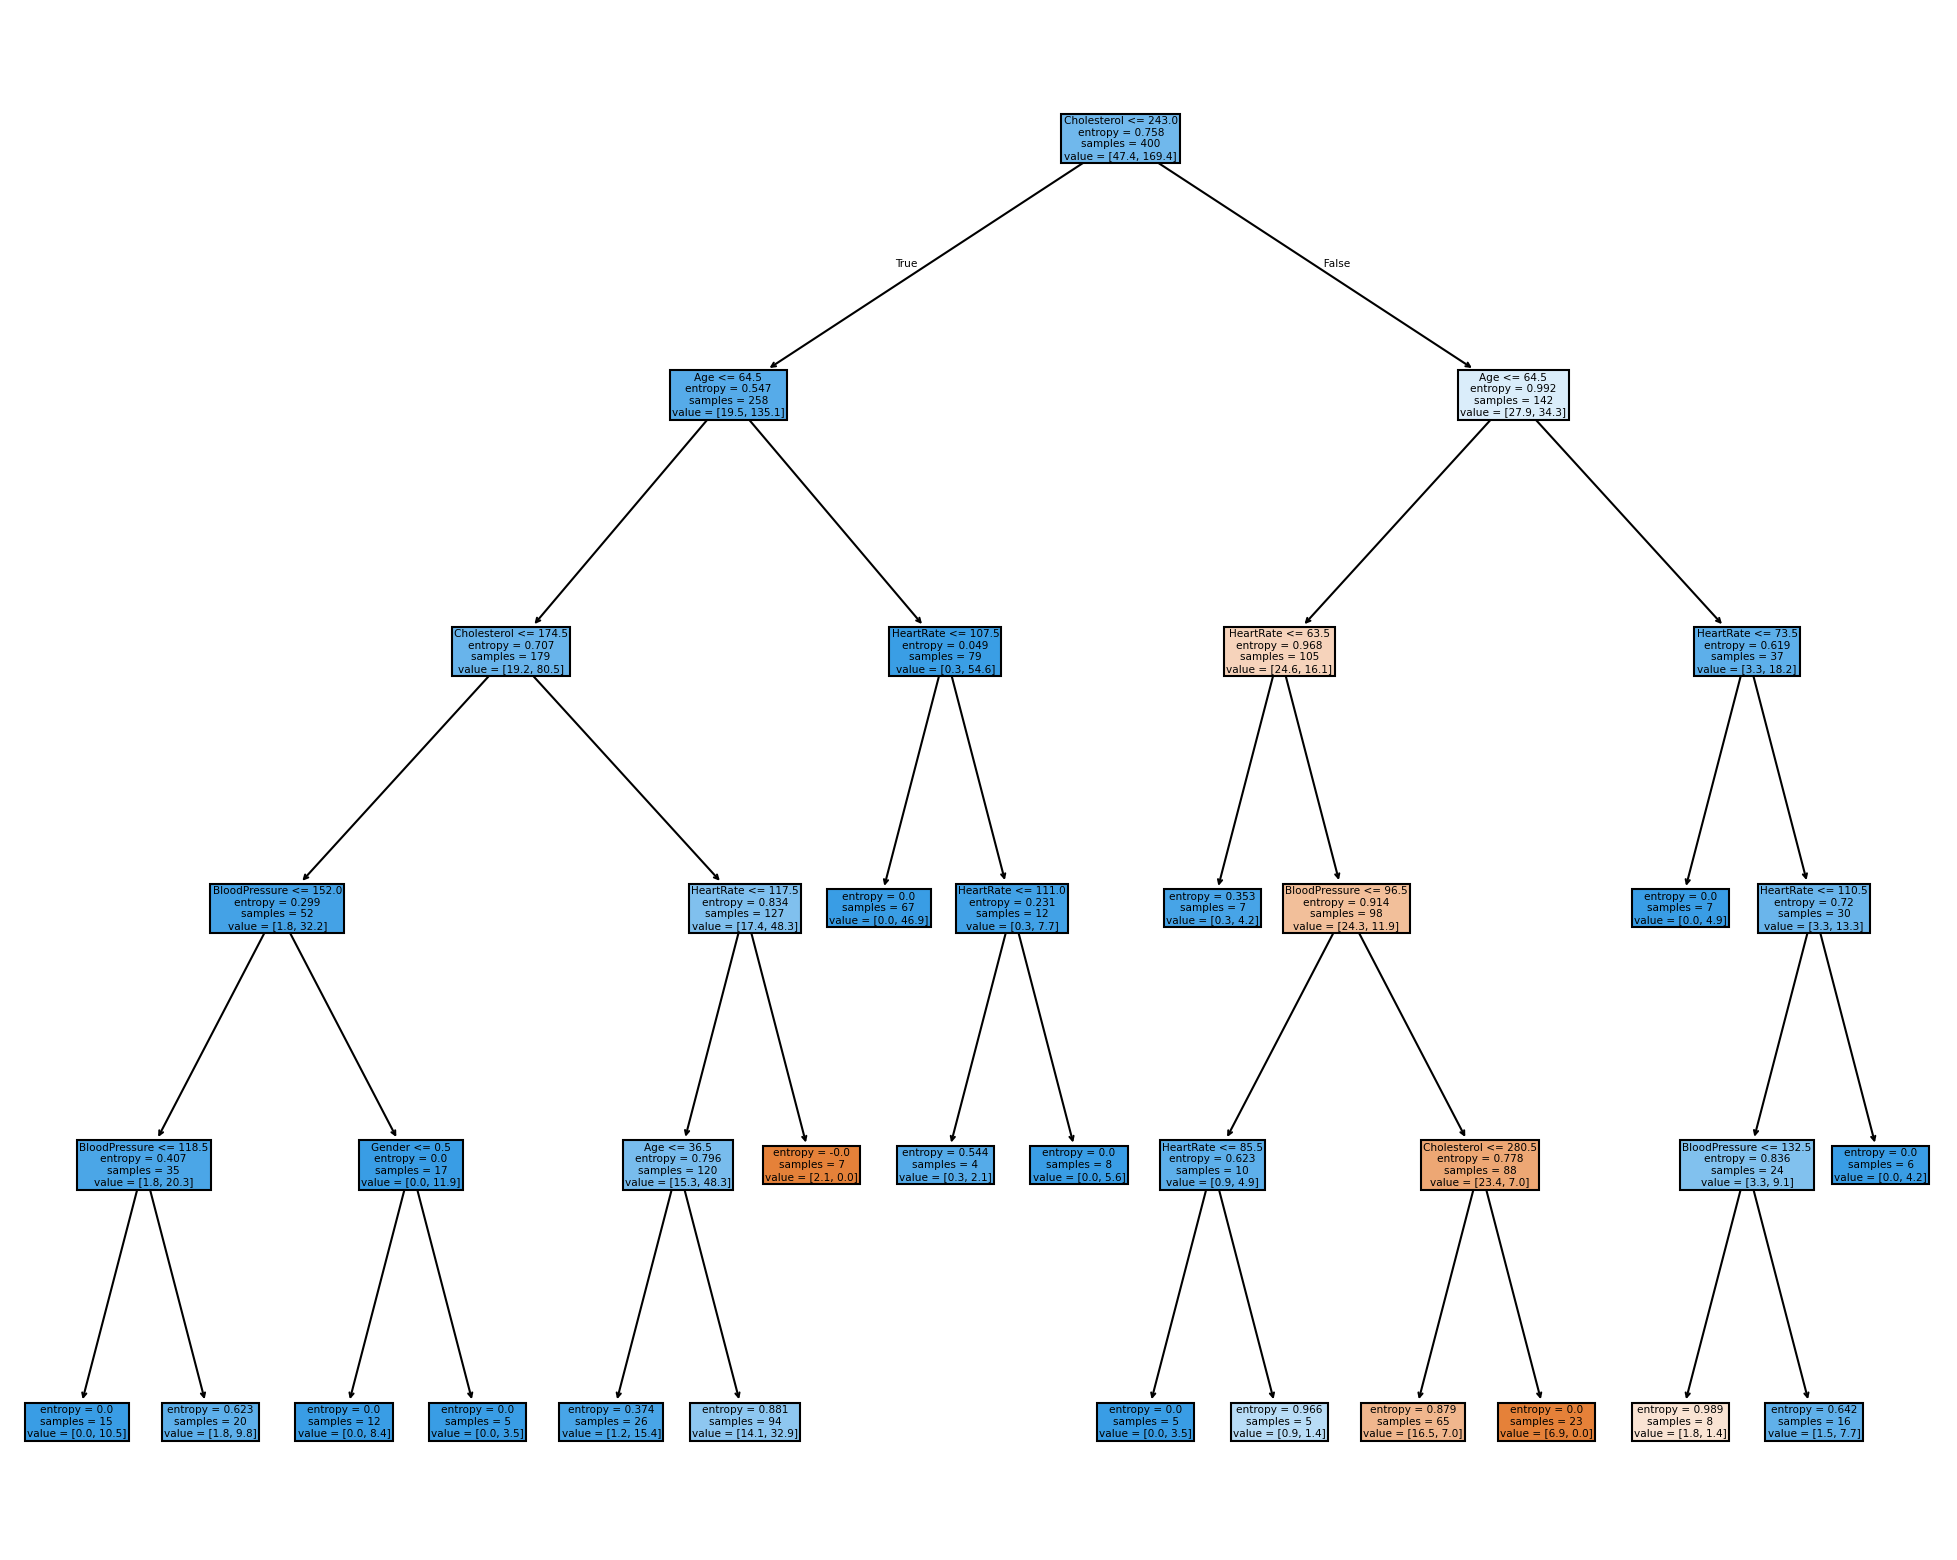

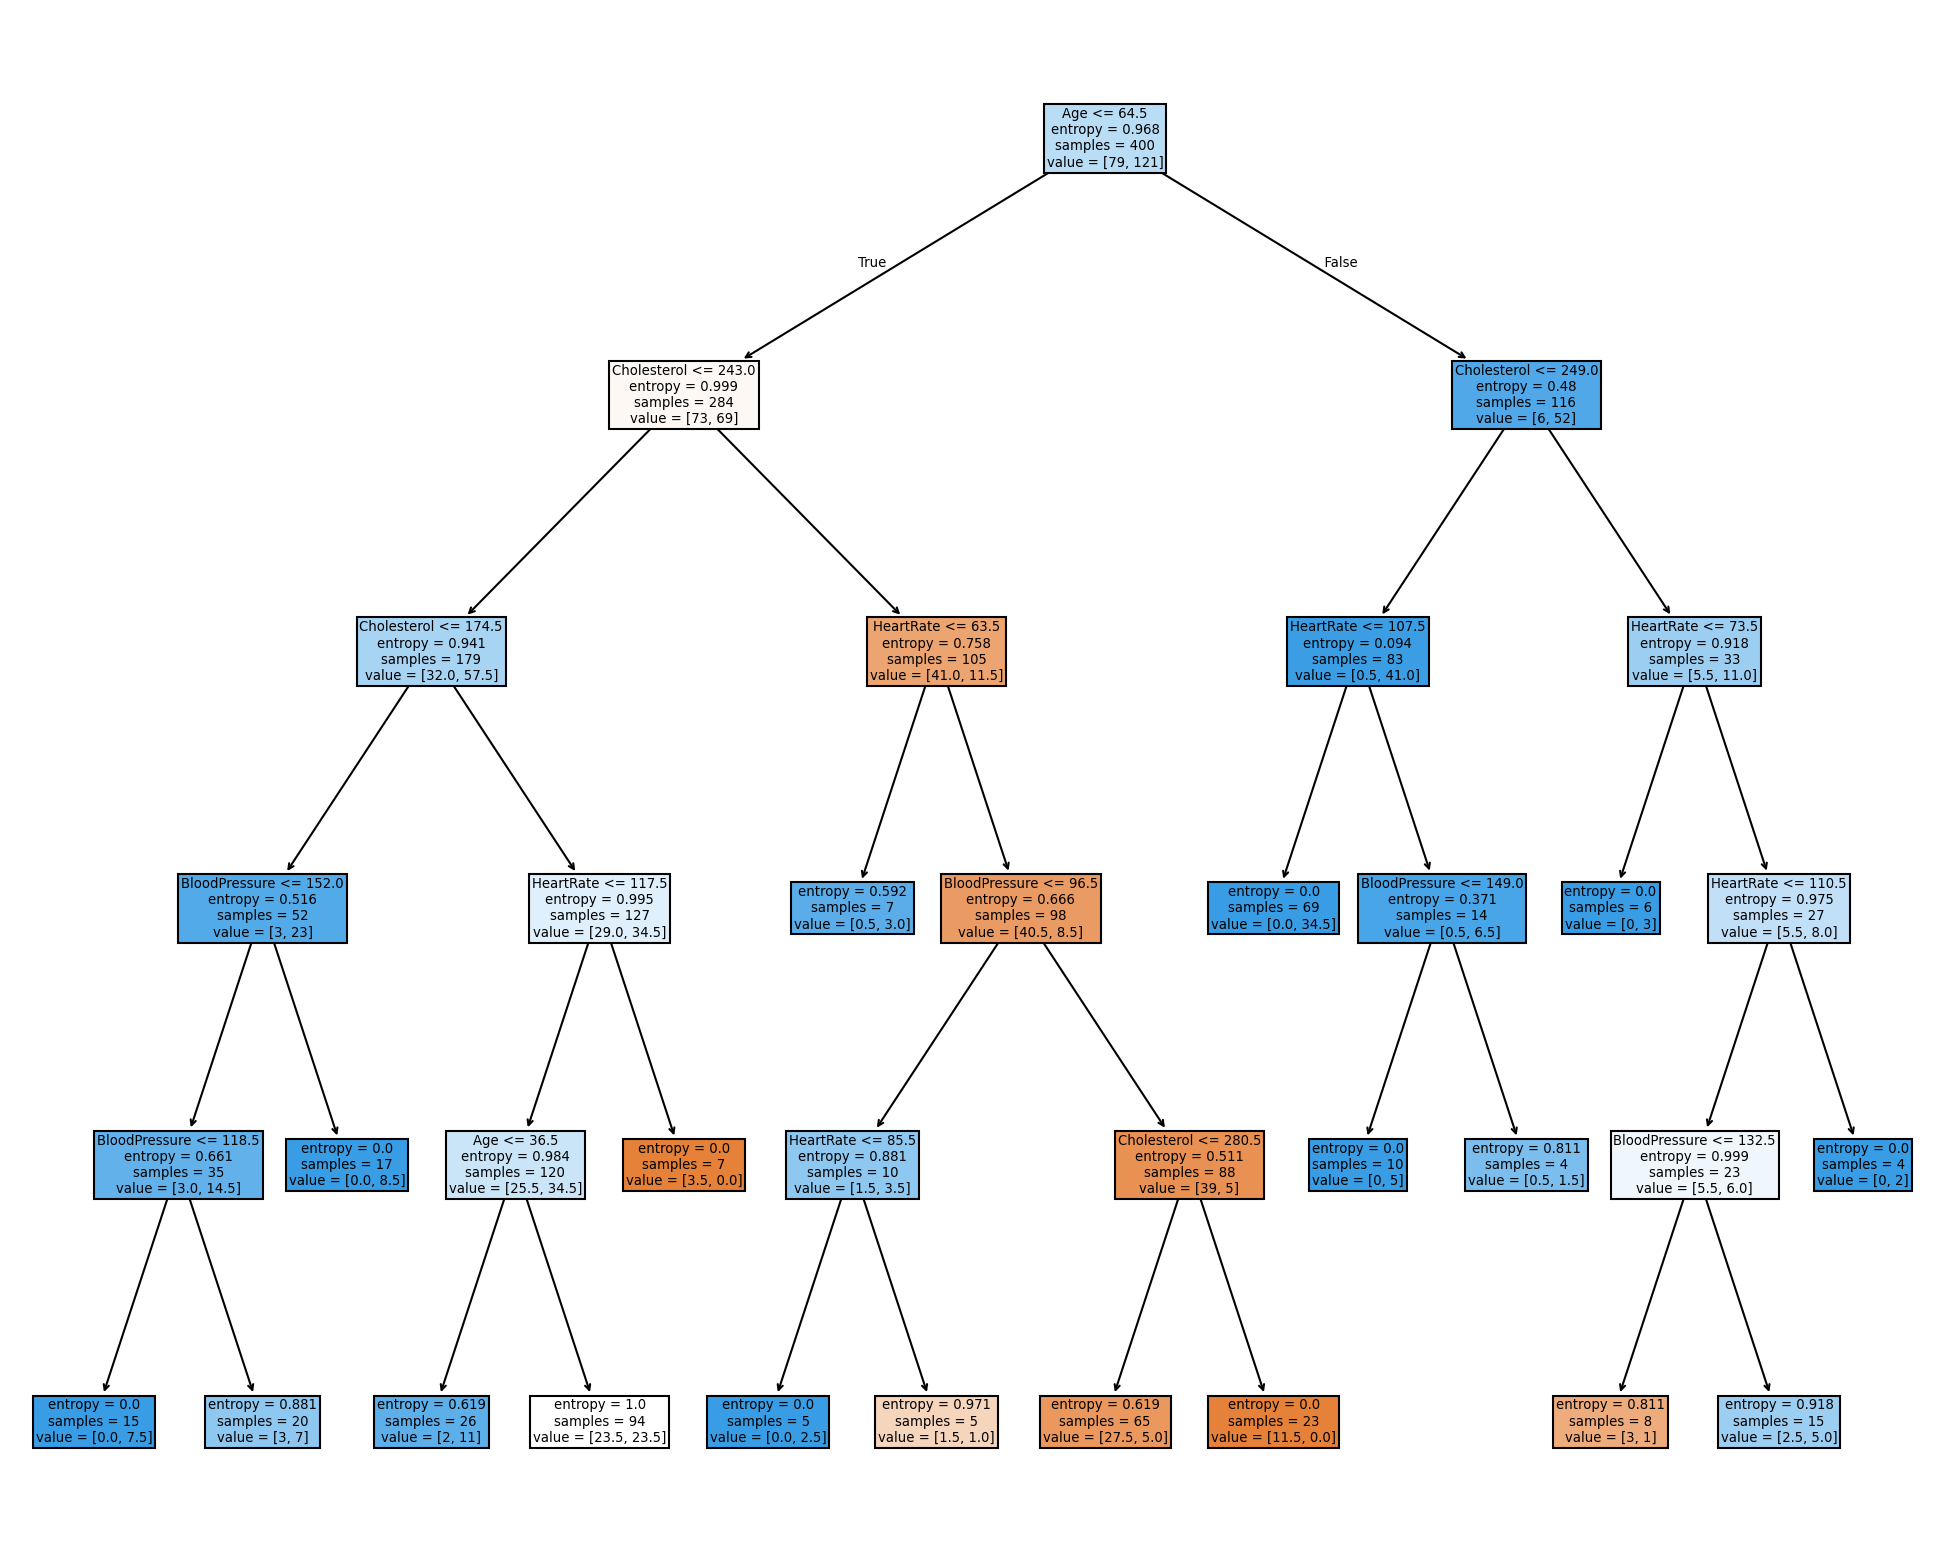

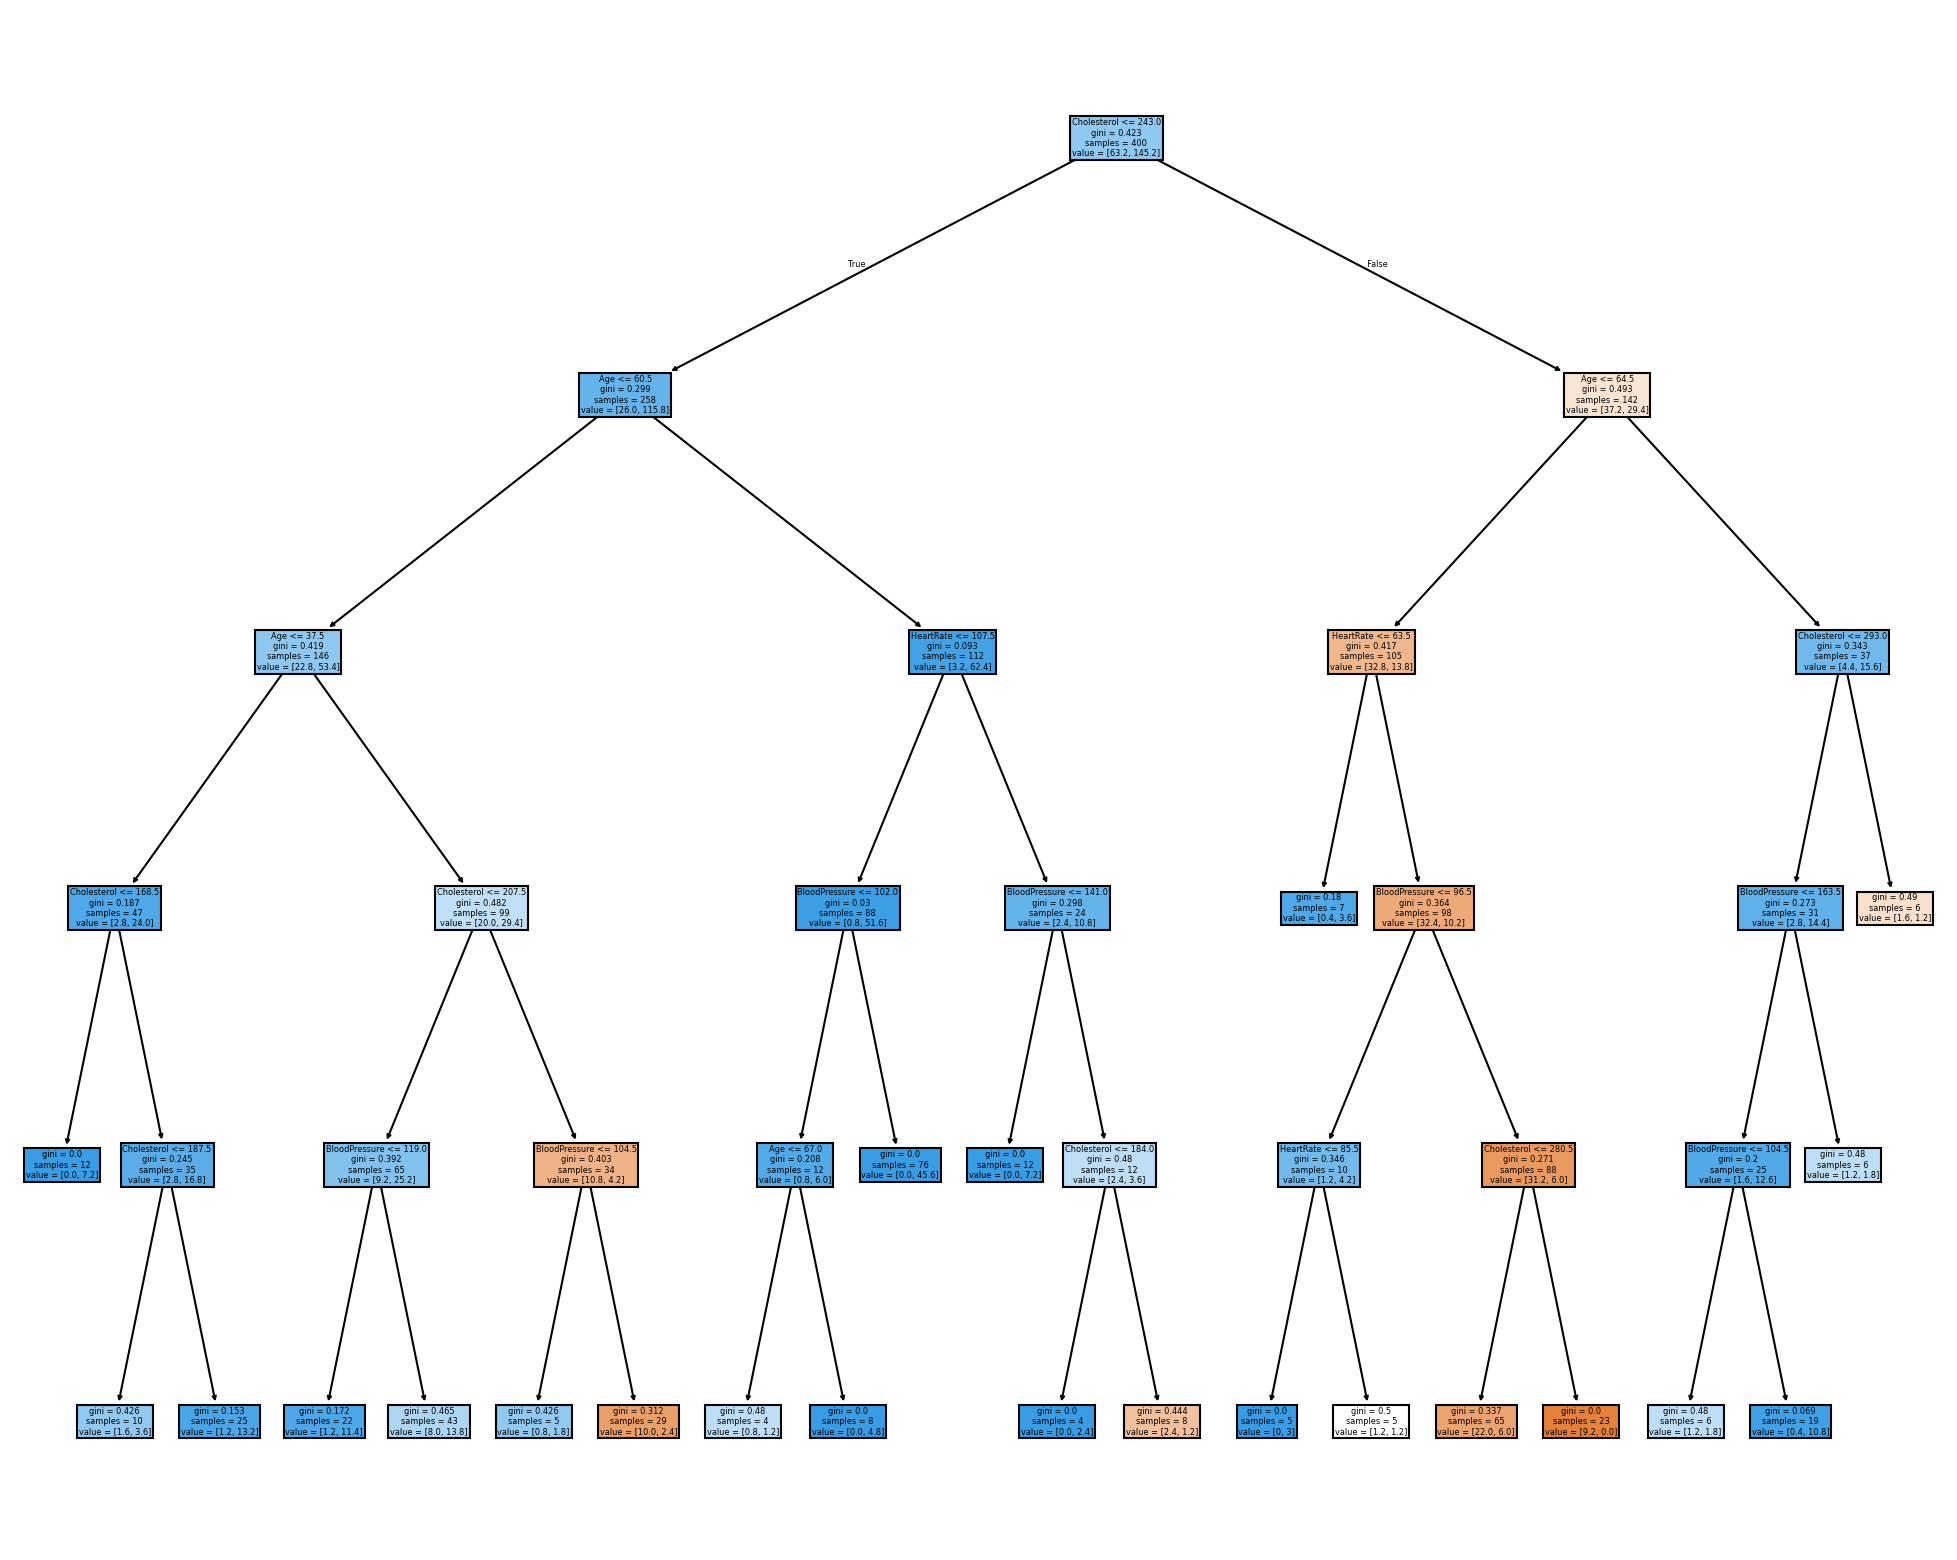

In [48]:
# Plot the decision trees
plot_decision_tree(dt_1_noQPF_model, feature_names)
plot_decision_tree(dt_2_noQPF_model, feature_names)
plot_decision_tree(dt_3_noQPF_model, feature_names)

Although Age was not considered in the models that used QuantumPatternFeature it was a prominent feature in the models that didn't use the QuantumPatternFeature. In all three models Cholesterol and Age were always used to classify a person has either having or not having Heart Disease. In general high Age, low Cholesterol, both high and low HeartRate and both high and low BloodPressure showed signs were indications of Heart Disease which is something Logistic Regression was not able to show. Gender did not appear to have any significant effect. In terms of model interpretability; gini modles despite preferming slightly worse than the entropy models are clearer with more meaningful splitting.

In [49]:
dt_1_noQPF_preds = dt_1_noQPF_model.predict(X_test_noQPF)
dt_cf1_noQPF = confusion_matrix(y_test, dt_1_noQPF_preds)
dt_2_noQPF_preds = dt_2_noQPF_model.predict(X_test_noQPF)
dt_cf2_noQPF = confusion_matrix(y_test, dt_2_noQPF_preds)
dt_3_noQPF_preds = dt_3_noQPF_model.predict(X_test_noQPF)
dt_cf3_noQPF = confusion_matrix(y_test, dt_3_noQPF_preds)

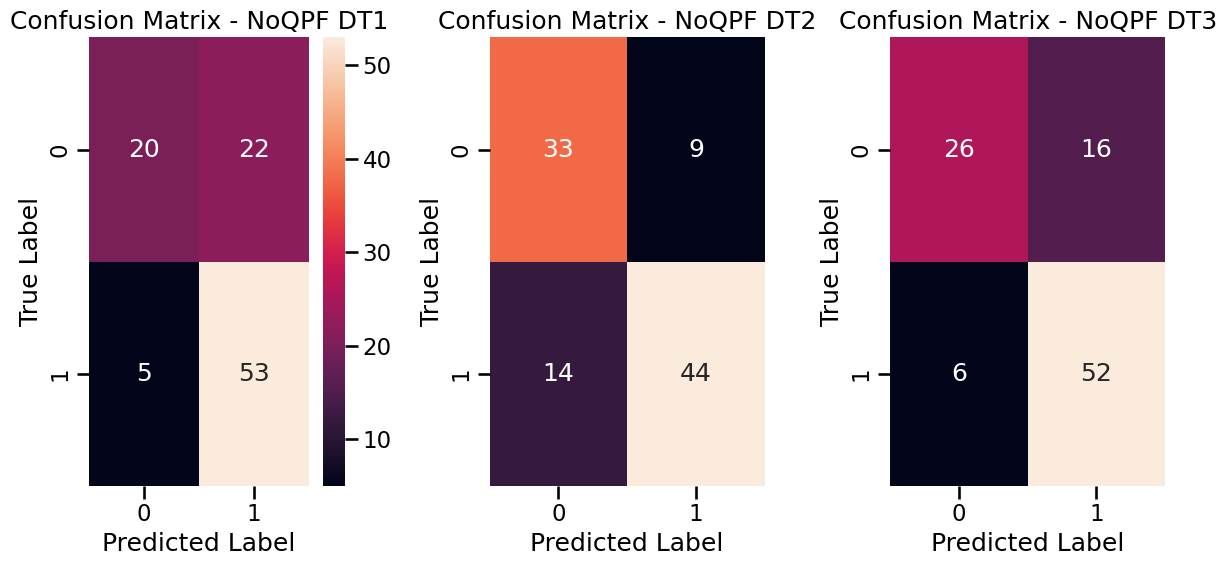

In [50]:
# Set the plot context for larger fonts and elements
sns.set_context('talk')

# Create the figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(dt_cf1_noQPF, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=True)
plt.title("Confusion Matrix - NoQPF DT1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the second confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(dt_cf2_noQPF, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=False)
plt.title("Confusion Matrix - NoQPF DT2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the third confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(dt_cf3_noQPF, annot=True, xticklabels=dt_1_model.classes_, yticklabels=dt_1_model.classes_, cbar=False)
plt.title("Confusion Matrix - NoQPF DT3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

It is clear that the models without the QuantumPatternFeature perform significantly worse. There does appear to be a benefit to weighting the classes in terms of recall however this does not necessarily correlate to more correct predictions.

### Random Forest

In [51]:
filtered_rf_results[filtered_rf_results['mean_test_f1'] > 0.9].sort_values(by='mean_test_recall', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
263,"{0: 0.3, 1: 0.7}",entropy,5,log2,2,5,100,0.272727,0.031656,0.920,0.953333,0.911667,0.917145,0.934530
262,"{0: 0.3, 1: 0.7}",entropy,5,log2,2,5,50,0.140591,0.025302,0.918,0.953333,0.909167,0.914395,0.933032
244,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,2,5,50,0.143819,0.025022,0.918,0.953333,0.909167,0.914395,0.933032
52,"{0: 0.3, 1: 0.7}",gini,5,log2,4,5,50,0.197772,0.036124,0.912,0.953333,0.901667,0.905965,0.928513
51,"{0: 0.3, 1: 0.7}",gini,5,log2,4,5,25,0.106584,0.033659,0.908,0.953333,0.896667,0.900674,0.925468


In [52]:
filtered_rf_results[filtered_rf_results['mean_test_recall'] > 0.94].sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
238,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,1,5,50,0.147055,0.026271,0.922,0.95,0.9150,0.922646,0.935839
256,"{0: 0.3, 1: 0.7}",entropy,5,log2,1,5,50,0.144351,0.024901,0.922,0.95,0.9150,0.922646,0.935839
257,"{0: 0.3, 1: 0.7}",entropy,5,log2,1,5,100,0.281249,0.029884,0.922,0.95,0.9150,0.922658,0.935718
239,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,1,5,100,0.279500,0.031195,0.922,0.95,0.9150,0.922658,0.935718
132,"{0: 0.3, 1: 0.7}",gini,15,sqrt,2,2,25,0.104258,0.032094,0.922,0.94,0.9175,0.931380,0.934997


In [71]:
# Convert X_train and X_test from numpy array to pandas DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [54]:
# Define and train three models with high recall and f1 scores
rf_r_model = RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy', max_depth=5, max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=rs)
rf_r_model.fit(X_train_df, y_train)

rf_f1_model  = RandomForestClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='entropy', max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=rs)
rf_f1_model.fit(X_train_df, y_train)

rf_gini_model = RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='gini', max_depth=15, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=25, random_state=rs)
rf_gini_model.fit(X_train_df, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=15,
                       min_samples_leaf=2, n_estimators=25, random_state=734)

In [55]:
def visualise_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualise the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=np.array(feature_names)[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

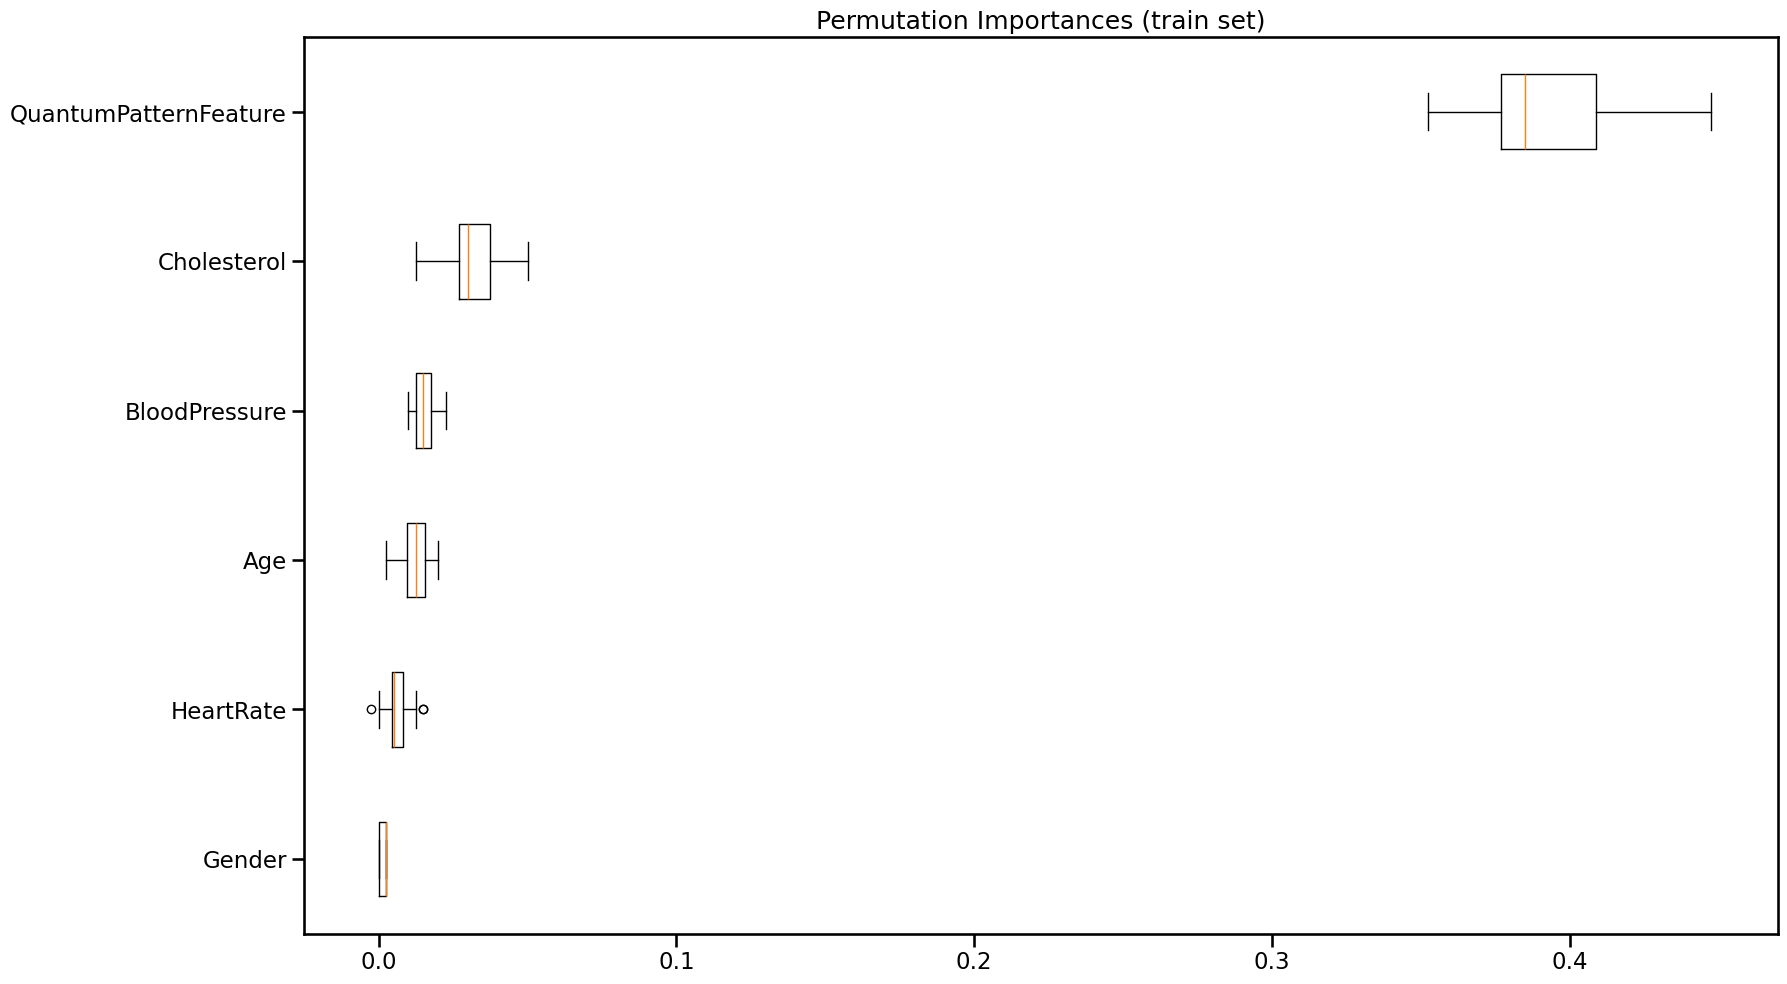

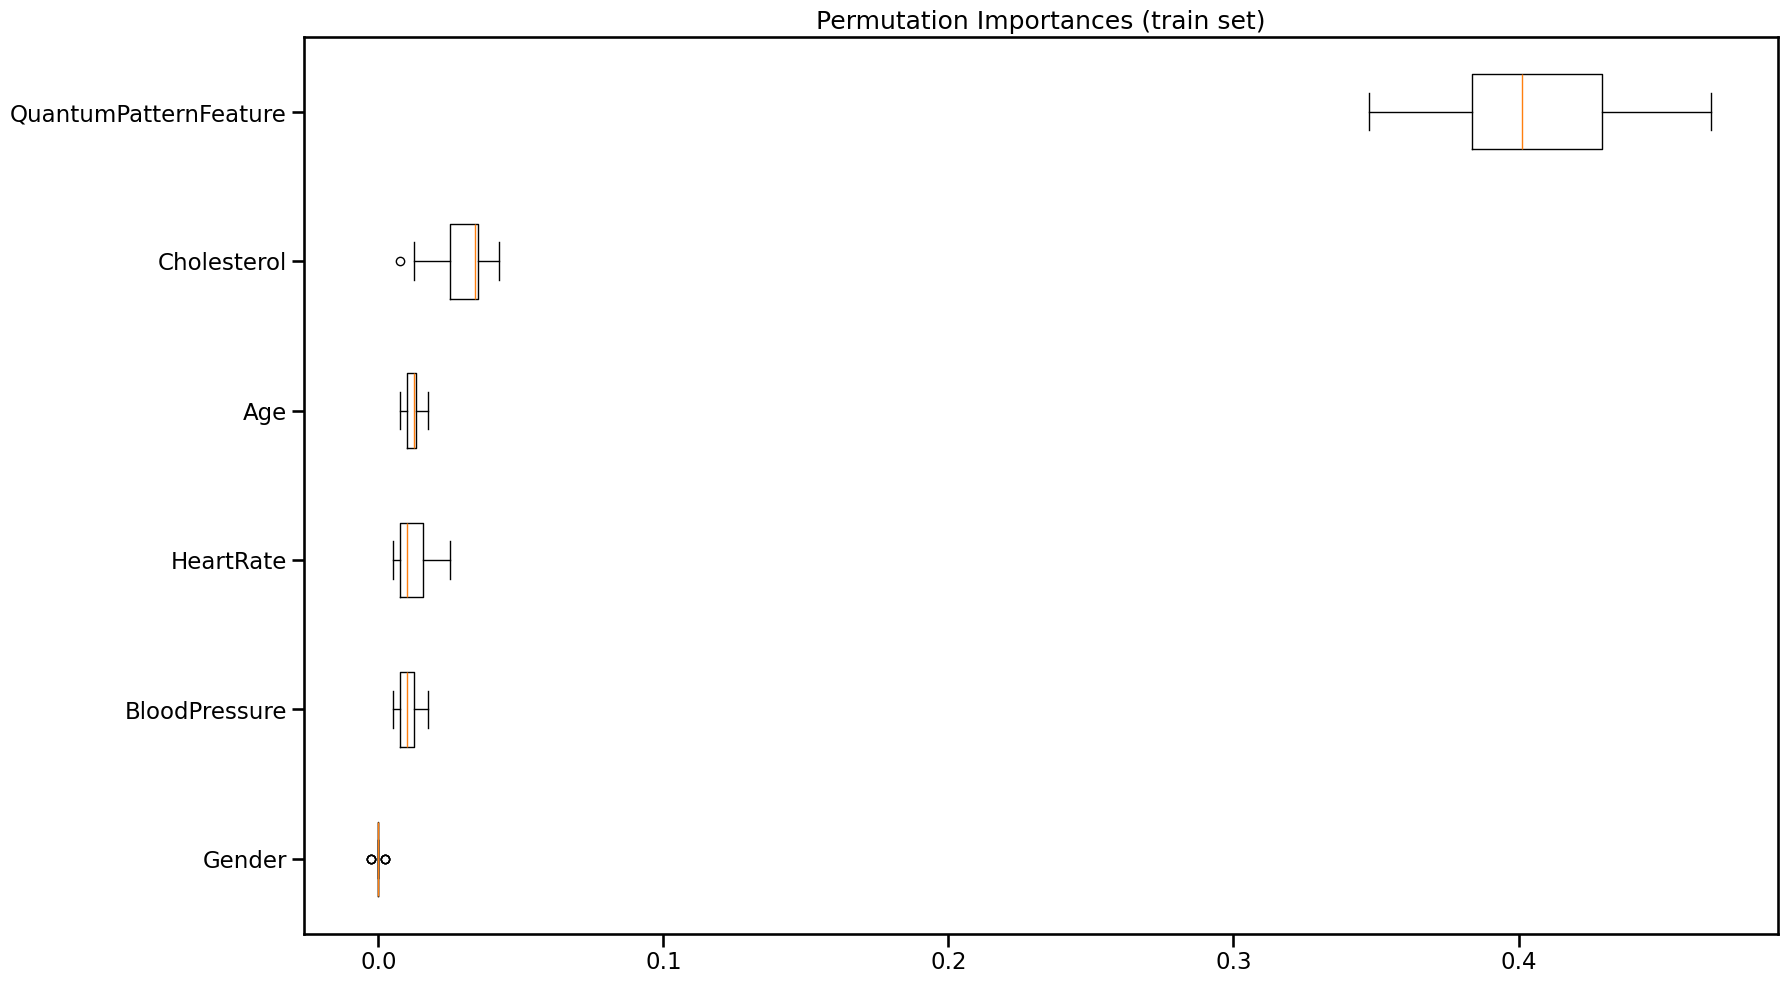

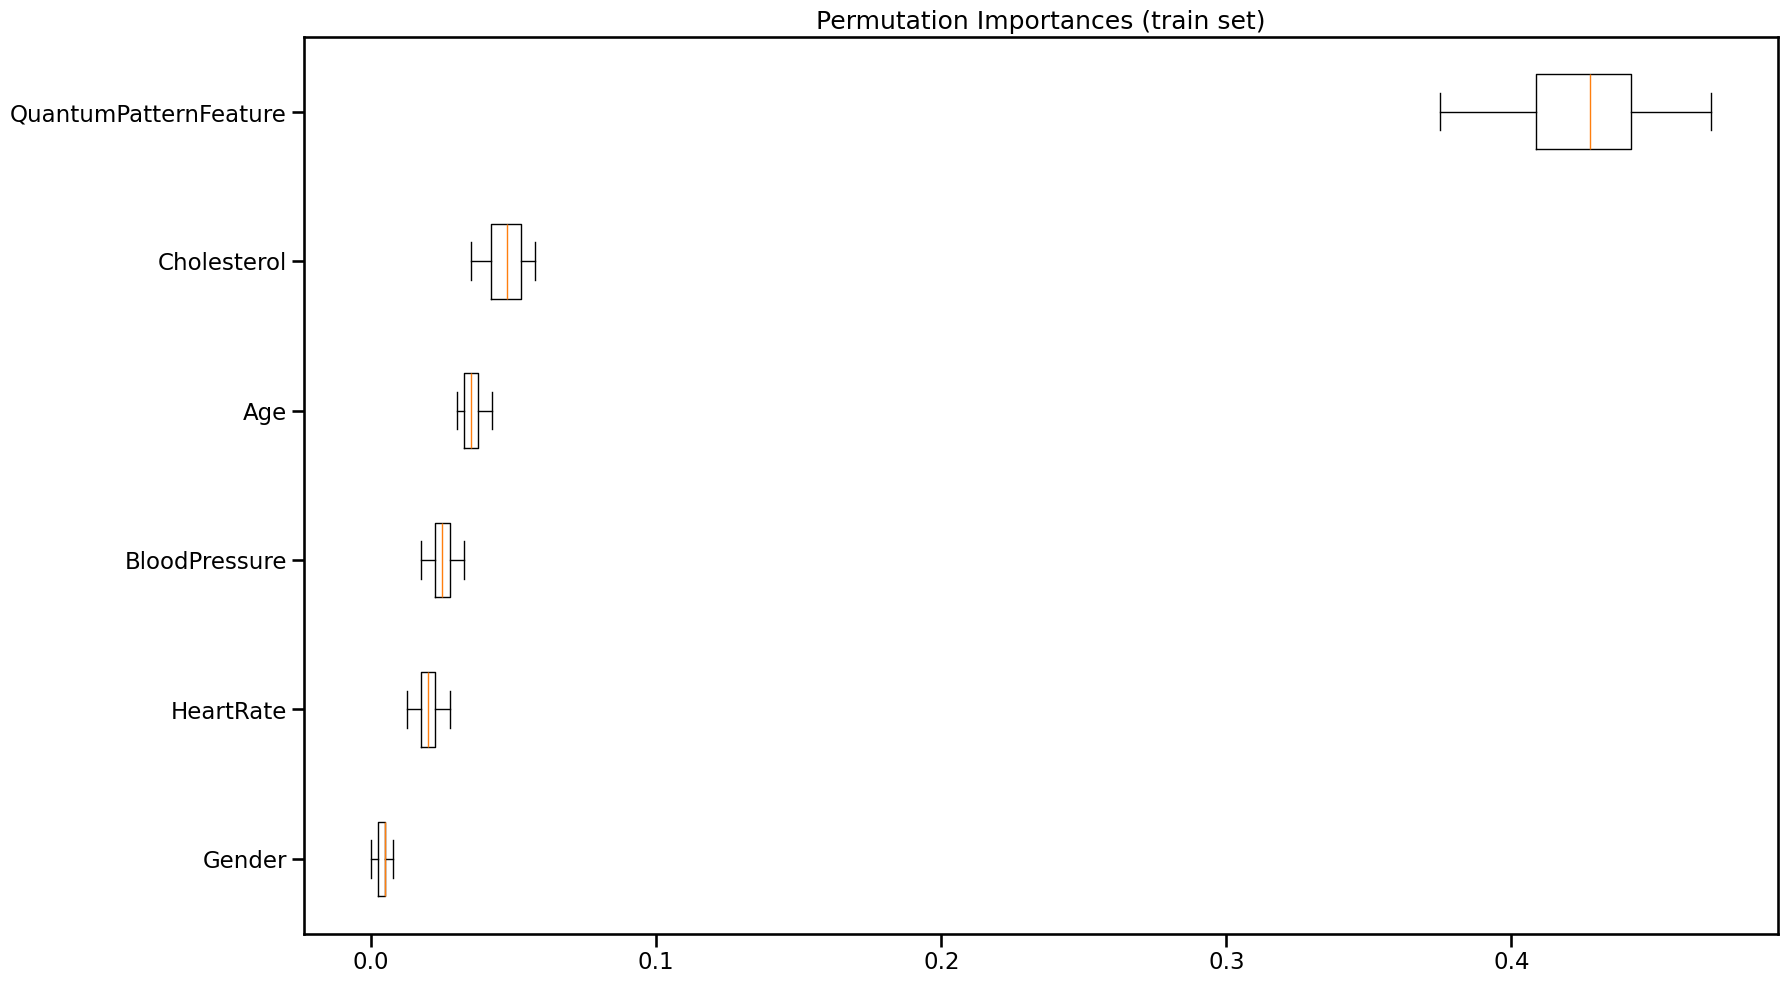

In [58]:
# Use permutation_importance to calculate permutation feature importances and visualise
feature_importances_r = permutation_importance(estimator=rf_r_model, X = X_train_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_r)

feature_importances_f1 = permutation_importance(estimator=rf_f1_model, X = X_train_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_f1)

feature_importances_gini = permutation_importance(estimator=rf_gini_model, X = X_train_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_gini)

QuantumPatternFeature is by far the most important feature with Cholesterol being the next most important. Gender is not an important feature.

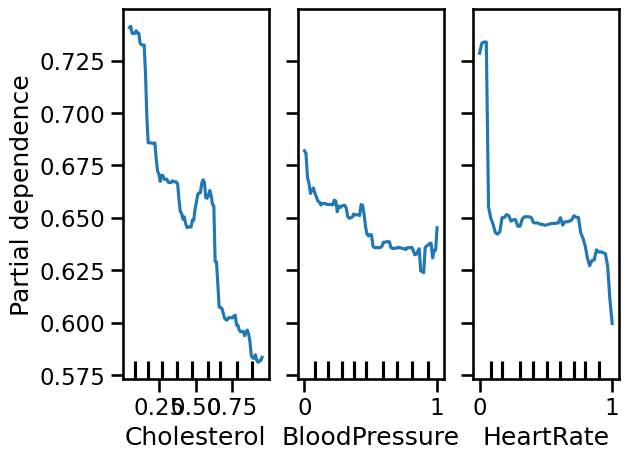

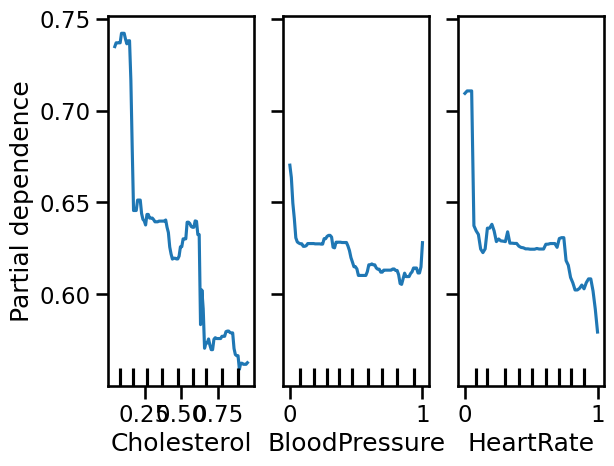

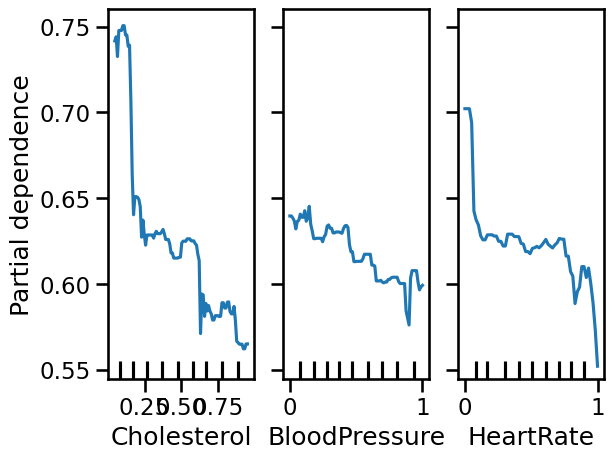

In [69]:
# Plot partial dependence
PartialDependenceDisplay.from_estimator(rf_r_model, 
                                        X=X_train_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])
PartialDependenceDisplay.from_estimator(rf_f1_model, 
                                        X=X_train_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])
PartialDependenceDisplay.from_estimator(rf_gini_model, 
                                        X=X_train_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])

The partial dependence plots show that low Cholesterol, BloodPressure and HeartRate are indications of Heart Disease. This is most pronounced in Cholesterol.

In [102]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    # Set the training dataset
    training_data=X_train_df.values,
    # Set the mode to be classification
    mode='classification',
    # Set class names
    class_names = ['No Heart Disease', 'Heart Disease'],
    # Set feature names
    feature_names=list(X_train_df.columns),
    random_state=rs,
    verbose=True)

In [107]:
instance_index = 30
selected_instance = X_test_df.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature
30,0.897959,1.0,0.382022,0.073826,0.322034,0.227269


Intercept 0.5179145520512437
Prediction_local [1.05810871]
Right: 0.9995904436860067


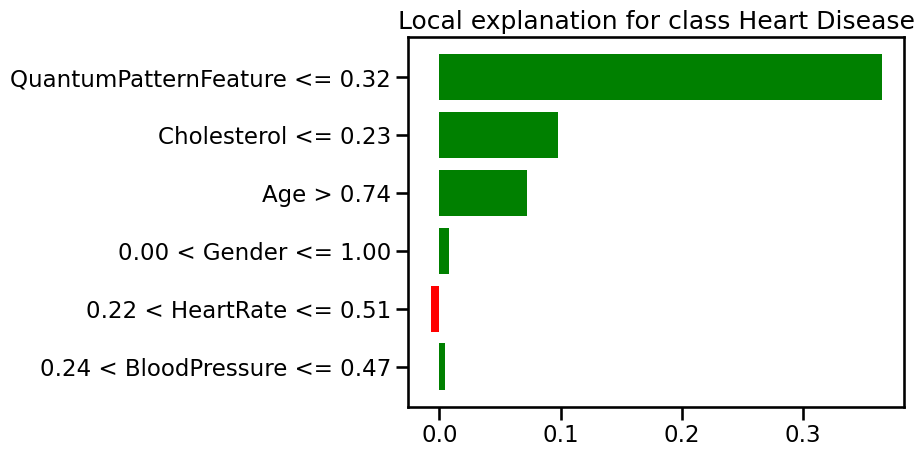

In [108]:
# Explain the instance
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from the model
                                 rf_r_model.predict_proba)
exp.as_pyplot_figure();

Explaination: Likely Heart Disease due to low QuantumPatternFeature, low Cholesterol, and high Age (Mostly the QuantumPatternFeature).

In [113]:
instance_index = 50
selected_instance = X_test_df.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature
50,0.020408,1.0,0.651685,0.557047,0.813559,0.637082


Intercept 0.8208807333682704
Prediction_local [0.16055199]
Right: 0.14421114930561024


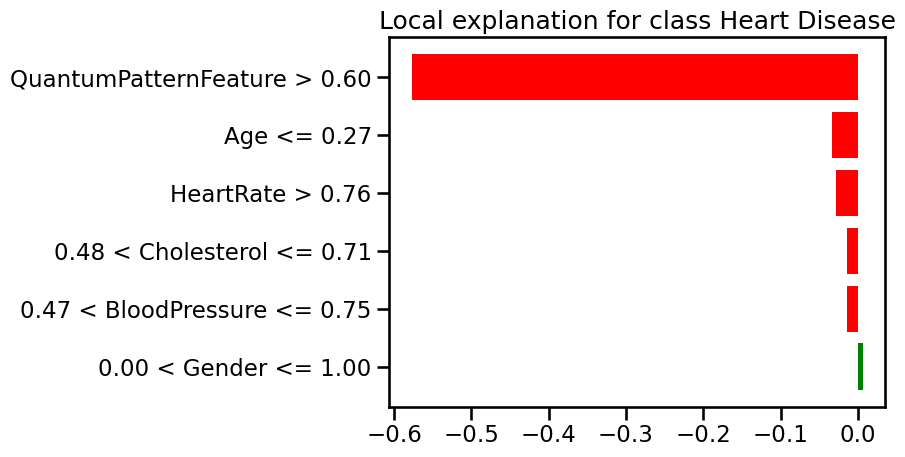

In [114]:
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from the model
                                 rf_r_model.predict_proba)
exp.as_pyplot_figure();

Explaination: Unlikely Heart Disease due to high QuantumPatternFeature, low Age, and high HeartRate (Mostly the QuantumPatternFeature).

In [147]:
rf_r_preds = rf_r_model.predict(X_test)
rf_cr = confusion_matrix(y_test, rf_r_preds)
rf_f1_preds = rf_f1_model.predict(X_test)
rf_cf1 = confusion_matrix(y_test, rf_f1_preds)
rf_gini_preds = rf_gini_model.predict(X_test)
rf_cgini = confusion_matrix(y_test, rf_gini_preds)

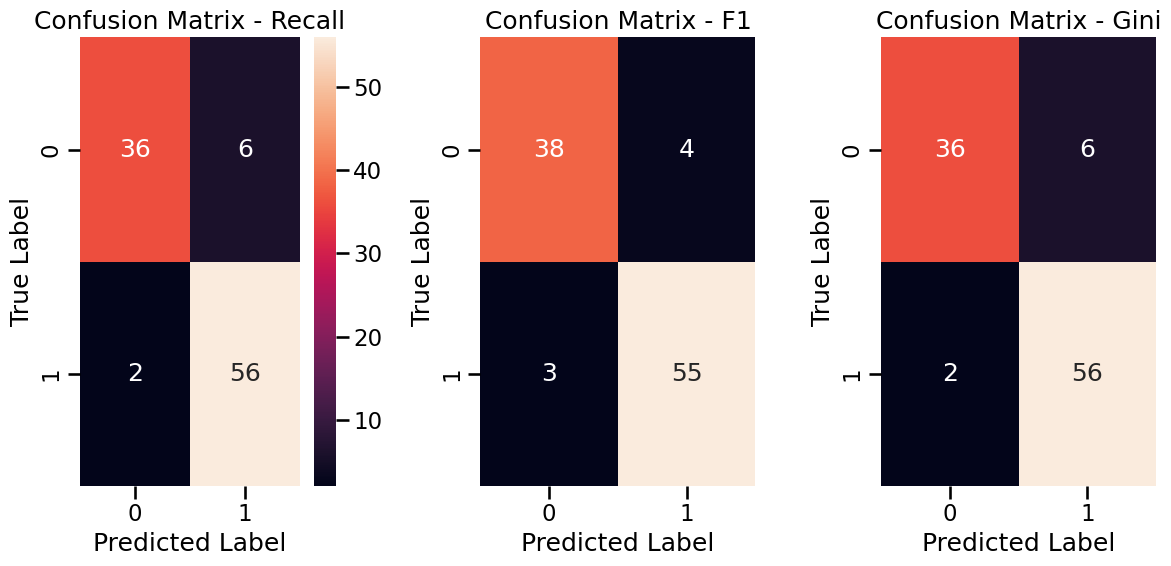

In [149]:
# Set the plot context for larger fonts and elements
sns.set_context('talk')

# Create the figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(rf_cr, annot=True, xticklabels=rf_r_model.classes_, yticklabels=rf_r_model.classes_, cbar=True)
plt.title("Confusion Matrix - Recall")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the second confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(rf_cf1, annot=True, xticklabels=rf_r_model.classes_, yticklabels=rf_r_model.classes_, cbar=False)
plt.title("Confusion Matrix - F1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the third confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(rf_cgini, annot=True, xticklabels=rf_r_model.classes_, yticklabels=rf_r_model.classes_, cbar=False)
plt.title("Confusion Matrix - Gini")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The matrices are comparable for those created by the Logistic Regression Models. The number of false negatives in all three models are low.

In [116]:
# Get the optimal parameters for Random Forest
rf_grid_noQPF_search = grid_search_rf(X_noQPF, y)
rf_noQPF_results = pd.DataFrame(rf_grid_noQPF_search.cv_results_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [117]:
filtered_rf_noQPF_results = rf_noQPF_results.filter(like='param_').join(rf_noQPF_results.filter(like='mean_'))
filtered_rf_noQPF_results.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
830,"{0: 0.4, 1: 0.6}",entropy,20,sqrt,1,2,100,0.439195,0.045709,0.796,0.856667,0.780833,0.815397,0.834580
848,"{0: 0.4, 1: 0.6}",entropy,20,log2,1,2,100,0.290733,0.031361,0.796,0.856667,0.780833,0.815397,0.834580
794,"{0: 0.4, 1: 0.6}",entropy,15,log2,1,2,100,0.424598,0.044134,0.796,0.856667,0.780833,0.814832,0.834569
776,"{0: 0.4, 1: 0.6}",entropy,15,sqrt,1,2,100,0.351439,0.035913,0.796,0.856667,0.780833,0.814832,0.834569
590,"{0: 0.4, 1: 0.6}",gini,15,log2,4,2,100,0.380680,0.048631,0.790,0.873333,0.769167,0.797430,0.832907


In [127]:
filtered_rf_noQPF_results[filtered_rf_results['mean_test_f1'] > 0.8].sort_values(by='mean_test_recall', ascending=False).head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_recall,mean_test_auc,mean_test_precision,mean_test_f1
240,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,2,2,25,0.103174,0.032434,0.740,0.926667,0.693333,0.721683,0.810810
258,"{0: 0.3, 1: 0.7}",entropy,5,log2,2,2,25,0.100793,0.030647,0.740,0.926667,0.693333,0.721683,0.810810
266,"{0: 0.3, 1: 0.7}",entropy,5,log2,4,2,100,0.391381,0.046765,0.744,0.923333,0.699167,0.726826,0.812857
248,"{0: 0.3, 1: 0.7}",entropy,5,sqrt,4,2,100,0.367482,0.041409,0.744,0.923333,0.699167,0.726826,0.812857
269,"{0: 0.3, 1: 0.7}",entropy,5,log2,4,5,100,0.364813,0.042311,0.744,0.923333,0.699167,0.726826,0.812857


In [136]:
# Convert X_train_noQPF and X_test_noQPF from numpy array to pandas DataFrame
X_train_noQPF_df = pd.DataFrame(X_train_noQPF, columns=feature_names[:-1])
X_test_noQPF_df = pd.DataFrame(X_test_noQPF, columns=feature_names[:-1])

In [137]:
# Define and train three models with high recall and f1 scores
rf_r_noQPF_model = RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy', max_depth=5, max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=25, random_state=rs)
rf_r_noQPF_model.fit(X_train_noQPF_df, y_train)

rf_f1_noQPF_model  = RandomForestClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='entropy', max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=rs)
rf_f1_noQPF_model.fit(X_train_noQPF_df, y_train)

rf_gini_noQPF_model = RandomForestClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=15, max_features='log2', min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=rs)
rf_gini_noQPF_model.fit(X_train_noQPF_df, y_train)

RandomForestClassifier(class_weight={0: 0.4, 1: 0.6}, max_depth=15,
                       max_features='log2', min_samples_leaf=4,
                       random_state=734)

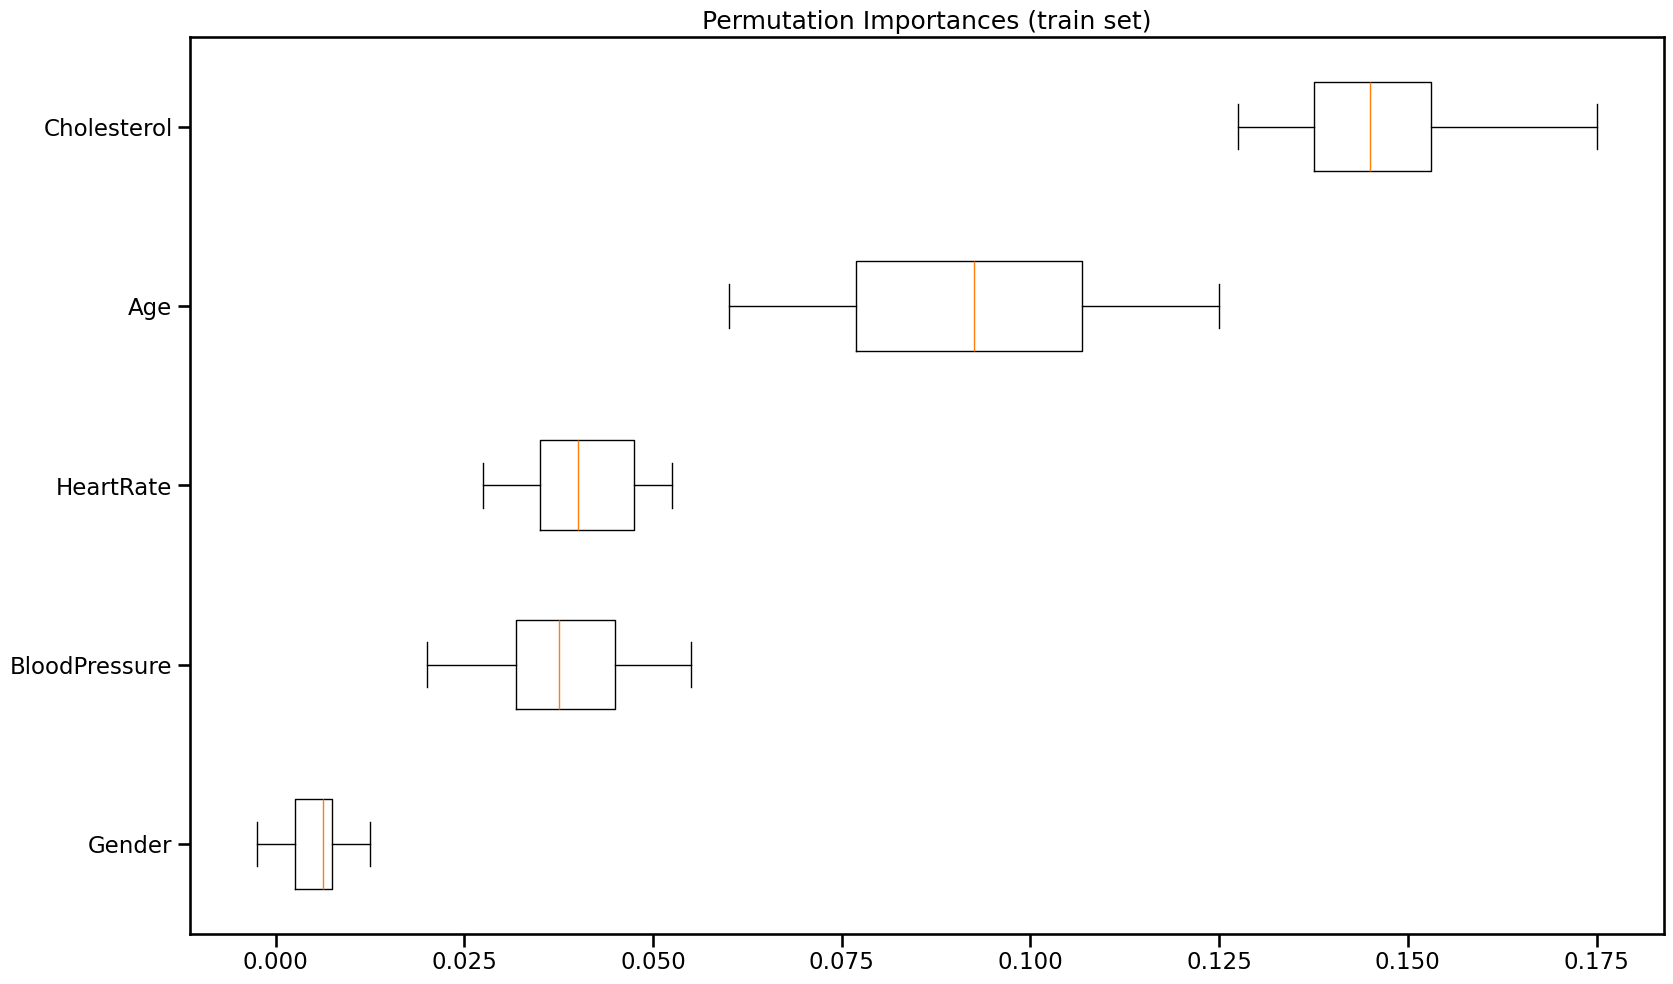

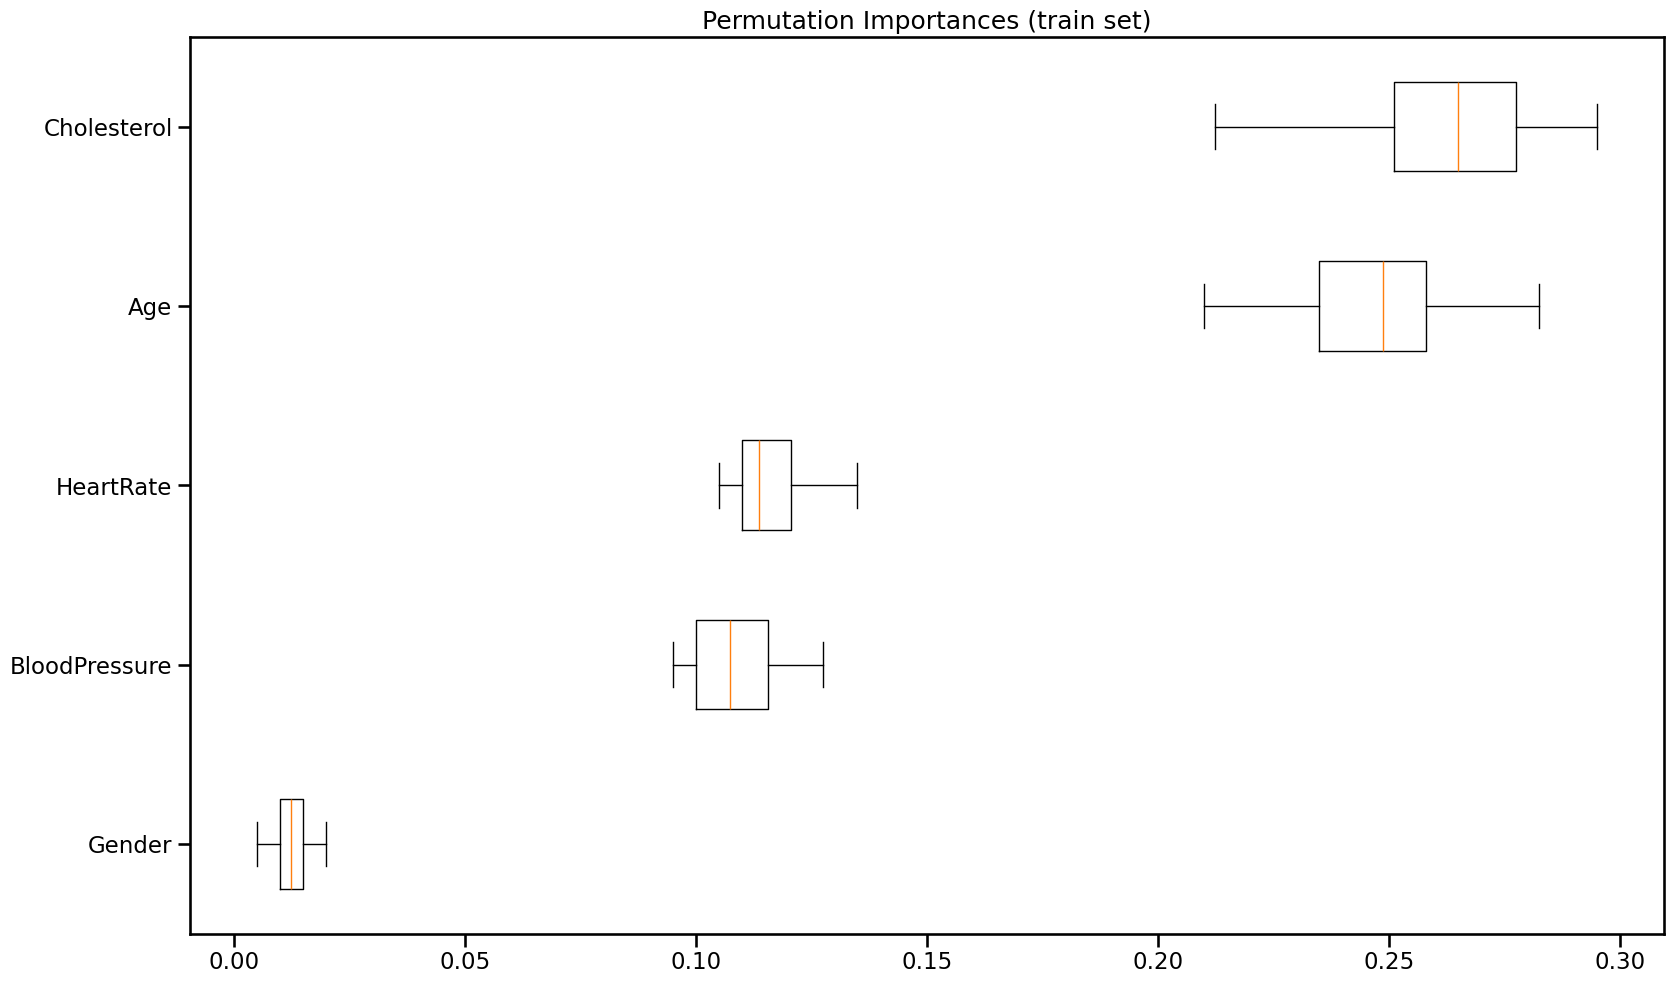

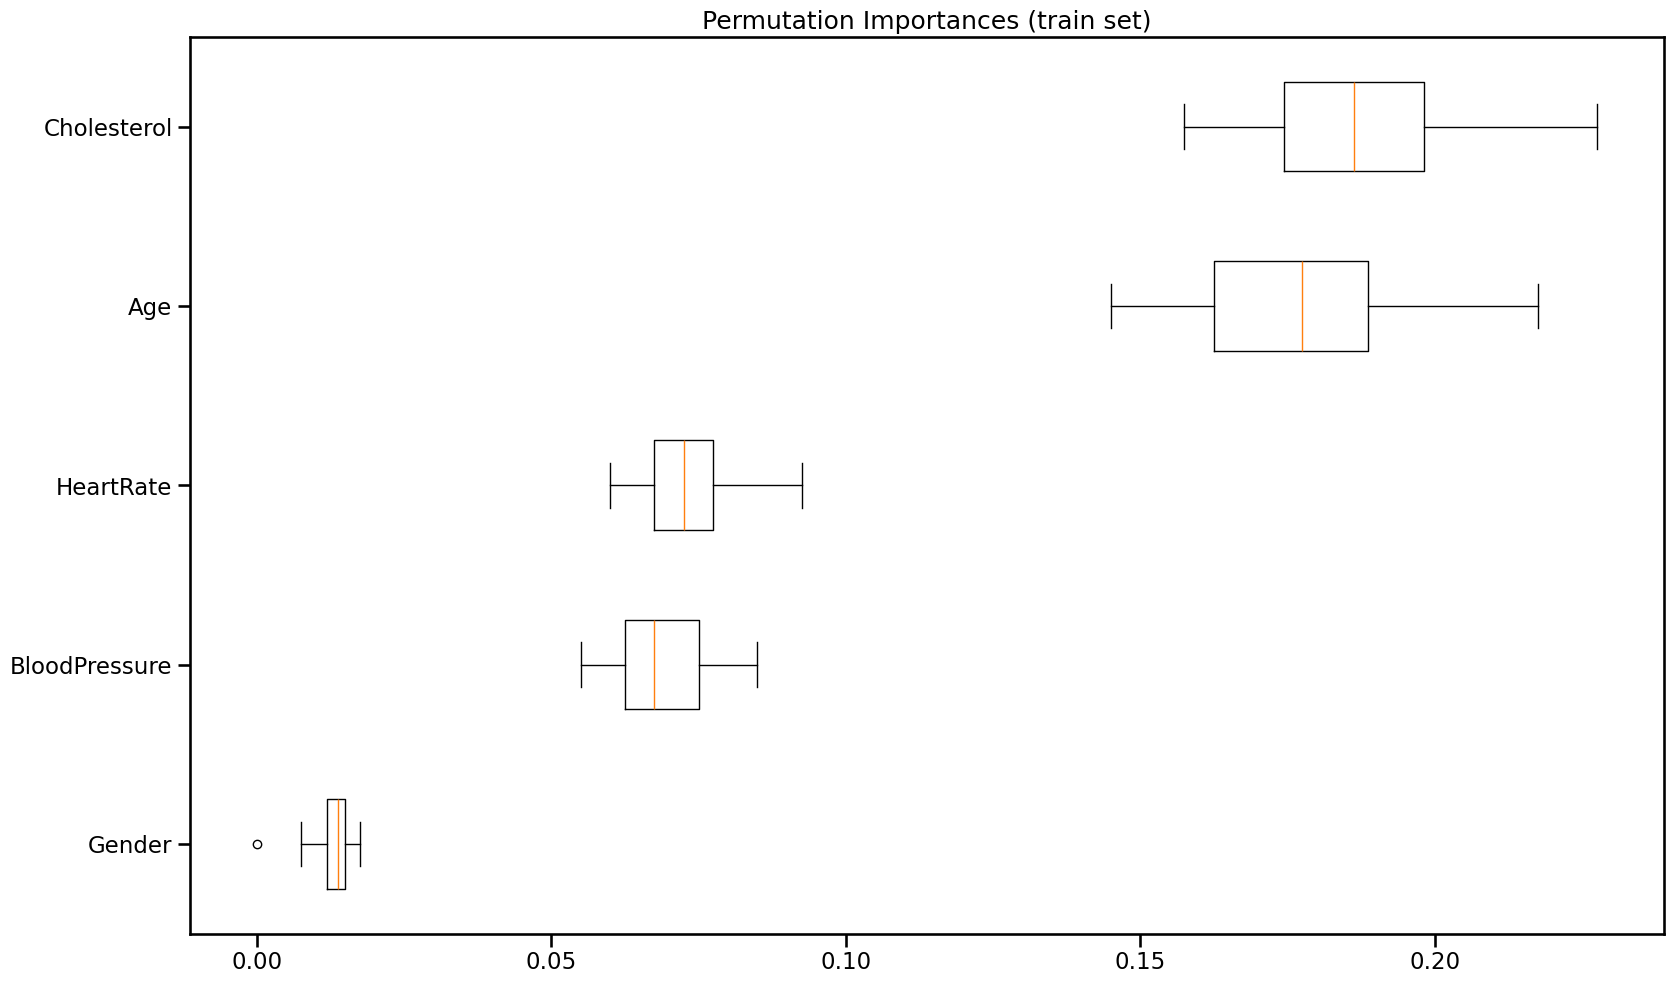

In [138]:
# Use permutation_importance to calculate permutation feature importances and visualise
feature_importances_r_noQPF = permutation_importance(estimator=rf_r_noQPF_model, X = X_train_noQPF_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_r_noQPF)

feature_importances_f1_noQPF = permutation_importance(estimator=rf_f1_noQPF_model, X = X_train_noQPF_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_f1_noQPF)

feature_importances_gini_noQPF = permutation_importance(estimator=rf_gini_noQPF_model, X = X_train_noQPF_df, y = y_train, n_repeats=20,
                                random_state=rs, n_jobs=2)
visualise_feature_importance(feature_importances_gini_noQPF)

Cholesterol is the most important feature when QuantumPatternFeature is not included. This is closely followed by Age. HeartRate and BloodPressure are more important features than Gender.

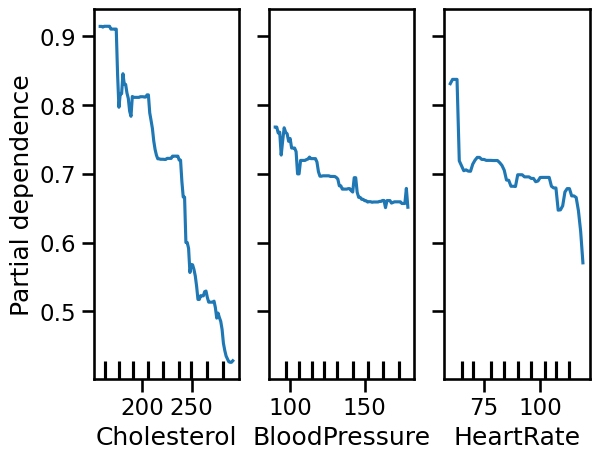

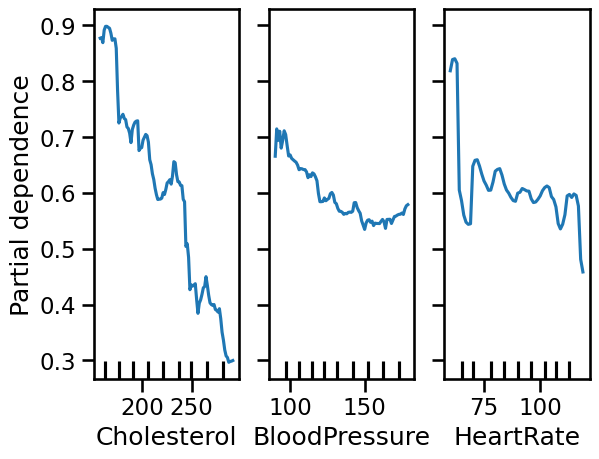

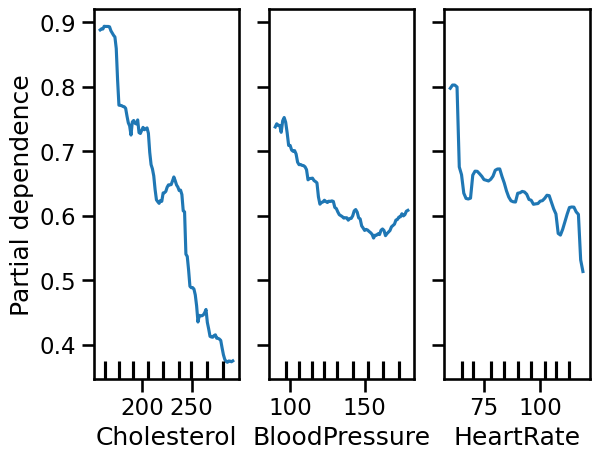

In [139]:
# Plot partial dependence
PartialDependenceDisplay.from_estimator(rf_r_noQPF_model, 
                                        X=X_train_noQPF_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])
PartialDependenceDisplay.from_estimator(rf_f1_noQPF_model, 
                                        X=X_train_noQPF_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])
PartialDependenceDisplay.from_estimator(rf_gini_noQPF_model, 
                                        X=X_train_noQPF_df, 
                                        features=['Cholesterol','BloodPressure','HeartRate'])

The relationships between Cholesterol, BloodPressure, and HeartRate with Heart Disease appear to be similar to when the QuantumPatternFeature was included.

In [140]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    # Set the training dataset
    training_data=X_train_noQPF_df.values,
    # Set the mode to be classification
    mode='classification',
    # Set class names
    class_names = ['No Heart Disease', 'Heart Disease'],
    # Set feature names
    feature_names=list(X_train_noQPF_df.columns),
    random_state=rs,
    verbose=True)

In [141]:
instance_index = 30
selected_instance = X_test_noQPF_df.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,Age,Gender,BloodPressure,Cholesterol,HeartRate
338,74,1,124,161,79


Intercept 0.5771322343131599
Prediction_local [1.08818641]
Right: 0.9866169753943247


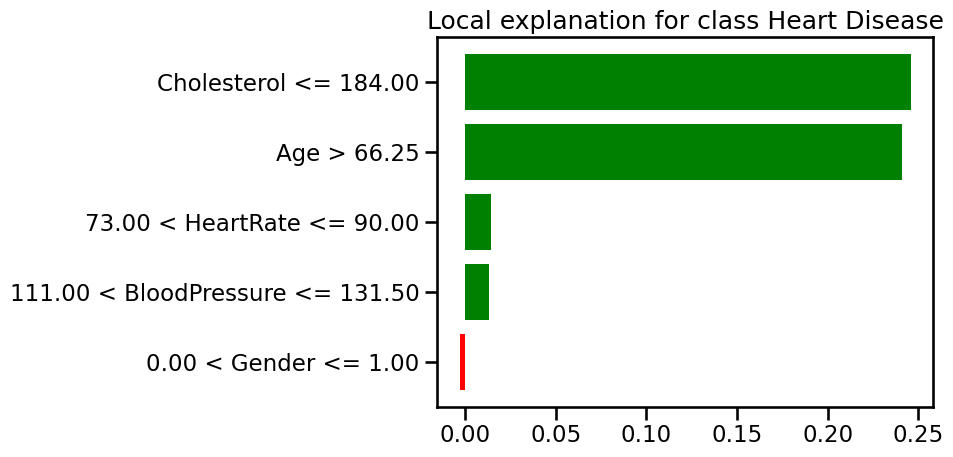

In [142]:
# Explain the instance
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from the model
                                 rf_r_noQPF_model.predict_proba)
exp.as_pyplot_figure();

Explaination: Likely Heart Disease predominately due to low Cholesterol and high Age.

In [143]:
instance_index = 50
selected_instance = X_test_noQPF_df.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,Age,Gender,BloodPressure,Cholesterol,HeartRate
424,31,1,148,233,108


Intercept 0.7650434417866928
Prediction_local [0.53370732]
Right: 0.5961996427867985


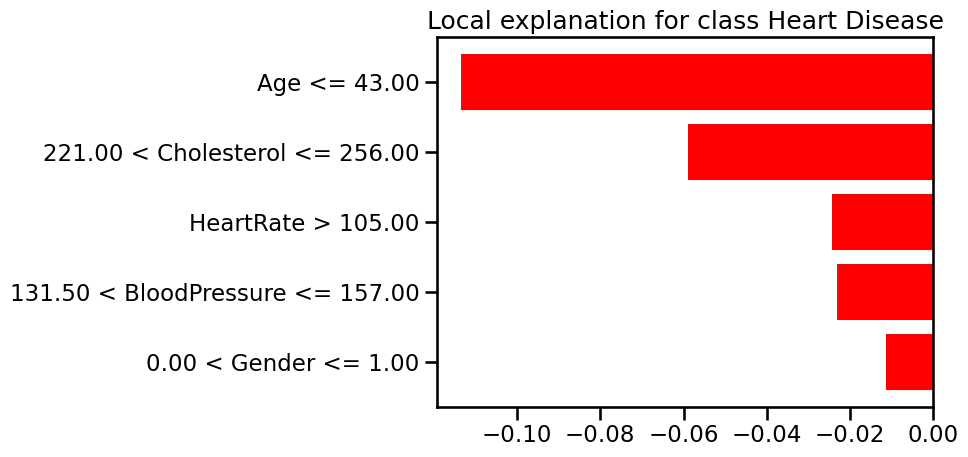

In [144]:
# Explain the instance
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from the model
                                 rf_r_noQPF_model.predict_proba)
exp.as_pyplot_figure();

Explaination: Unlikely Heart Disease predominately due to low Age and high Cholesterol, HeartRate and BloodPressure are more impactful for this instance.

In [150]:
rf_r_noQPF_preds = rf_r_noQPF_model.predict(X_test_noQPF)
rf_cr_noQPF = confusion_matrix(y_test, rf_r_noQPF_preds)
rf_f1_noQPF_preds = rf_f1_noQPF_model.predict(X_test_noQPF)
rf_cf1_noQPF = confusion_matrix(y_test, rf_f1_noQPF_preds)
rf_gini_noQPF_preds = rf_gini_noQPF_model.predict(X_test_noQPF)
rf_cgini_noQPF = confusion_matrix(y_test, rf_gini_noQPF_preds)

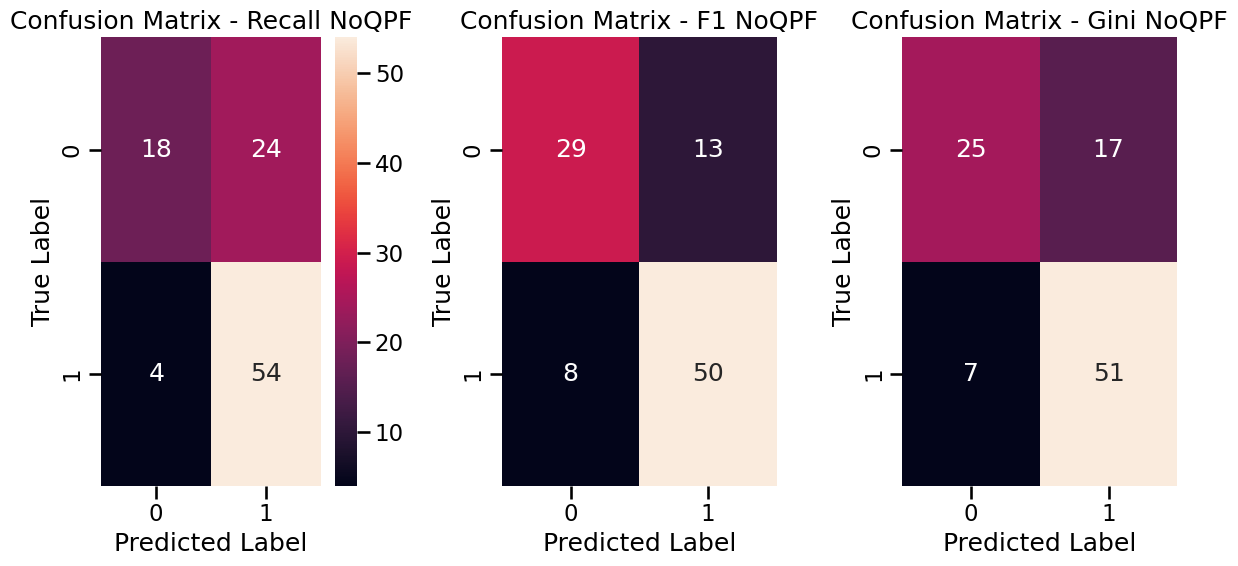

In [151]:
# Set the plot context for larger fonts and elements
sns.set_context('talk')

# Create the figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(rf_cr_noQPF, annot=True, xticklabels=rf_r_noQPF_model.classes_, yticklabels=rf_r_noQPF_model.classes_, cbar=True)
plt.title("Confusion Matrix - Recall NoQPF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the second confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(rf_cf1_noQPF, annot=True, xticklabels=rf_r_noQPF_model.classes_, yticklabels=rf_r_noQPF_model.classes_, cbar=False)
plt.title("Confusion Matrix - F1 NoQPF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot the third confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(rf_cgini_noQPF, annot=True, xticklabels=rf_r_noQPF_model.classes_, yticklabels=rf_r_noQPF_model.classes_, cbar=False)
plt.title("Confusion Matrix - Gini NoQPF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The models without the QuantumPatternFeature performed significantly worse but do a lot better than random guessing.

Main takeaways: 
* QuantumPatternFeature is a very good indicator of Heart Disease.
* Age and Cholesterol were the next most useful features for determining Heart Disease.
* RandomForest and DecisionTrees were not able to achieve a recall as good as Logistic Regression.
* High F1 and recalls were able to be achieved by all three machine learning algorithms.
* Overfitting and underfitting the dataset did not offer significant improvement however, weighting the classes did.